# Import library

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/abiyamf/miniconda3/envs/myenv/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [174]:
import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import asyncio
import nest_asyncio
import io
from dotenv import load_dotenv
from telegram import Bot, InputFile
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import mixed_precision

In [53]:
# Cek apakah ada GPU yang tersedia
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"TensorFlow mendeteksi {len(gpus)} GPU:")
    for gpu in gpus:
        print(gpu)
else:
    print("TensorFlow tidak mendeteksi GPU.")

TensorFlow mendeteksi 1 GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [54]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Define Fungsi

In [55]:
def model_parameter():
    # Membuat dictionary untuk menyimpan informasi jumlah parameter
    model_info = {
        'Model': ['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7'],
        'Total Parameters': []
    }
    
    # Menghitung jumlah parameter dari setiap model EfficientNet
    models = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]
    for model in models:
        model_instance = model(weights=None)  # Membuat instance dari model tanpa bobot pre-trained
        total_params = model_instance.count_params()  # Menghitung jumlah parameter
        model_info['Total Parameters'].append(total_params)
    
    # Membuat DataFrame dari dictionary
    df = pd.DataFrame(model_info)
    
    # Menambahkan pemisah ribuan (titik)
    df['Total Parameters'] = df['Total Parameters'].apply(lambda x: f"{x:,}".replace(",", "."))
    return df

In [100]:
def send_telegram_message(message):
    async def _send_message():
        load_dotenv()
        bot = Bot(token=os.getenv("TELEGRAM_TOKEN"))
        chat_id = os.getenv("TELEGRAM_CHAT_ID")
        await bot.send_message(chat_id=chat_id, text=message)

    # Jalankan coroutine menggunakan event loop
    loop = asyncio.get_event_loop()
    loop.run_until_complete(_send_message())

In [57]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [58]:
def build_and_compile_model_not_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [59]:
def build_and_compile_model_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze 50% layer pertama dari base model
    total_layers = len(base_model.layers)
    freeze_layers = int(0.50 * total_layers)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [60]:
def build_and_compile_model_trainable_None(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights=None)
    base_model.trainable = True

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [61]:
def build_and_compile_model_trainable_None_modifikasi(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights=None)
    base_model.trainable = True

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [95]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs, save_directory):
    try:
        send_telegram_message(f"Training {model_name} has started!")
        
        # Membuat folder penyimpanan jika belum ada
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
    
        # Membuat folder untuk menyimpan gambar
        images_save_directory = os.path.join(save_directory, 'images')
        if not os.path.exists(images_save_directory):
            os.makedirs(images_save_directory)
    
        # Menyusun nama file penyimpanan model dengan parameter model_name
        save_path = os.path.join(save_directory, f'best_model_{model_name}.keras')
    
        # Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
        checkpoint_callback = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, mode='max')
    
        # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
        early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
    
        # Menghitung waktu mulai pelatihan
        start_time = time.time()
        
        # Melatih model
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            # callbacks=[checkpoint_callback]
            callbacks=[checkpoint_callback, early_stopping_callback]
            
        )
        
        # Menghitung waktu selesai pelatihan
        end_time = time.time()
        
        # Menghitung durasi pelatihan
        training_duration = end_time - start_time  # dalam detik
    
        # Plotting hasil akurasi
        plt.figure(figsize=(12, 4))
    
        # Plot training & validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{model_name} Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    
        # Plot training & validation loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{model_name} Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    
        # Save the loss plot
        plt.savefig(os.path.join(images_save_directory, f'{model_name}_accuracy_loss.png'))
    
        # Tampilkan plot
        plt.show()
    
        # Evaluasi model pada data test
        test_loss, test_accuracy = model.evaluate(test_generator)
        print(f"Test Accuracy: {test_accuracy:.4f}")
    
        # Prediksi pada data test
        y_pred = model.predict(test_generator)
    
        # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
        y_pred_classes = np.argmax(y_pred, axis=1)
    
        # Mengambil label sebenarnya dari generator
        y_true = test_generator.classes
    
        # Membuat confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)
        class_names = list(test_generator.class_indices.keys())
    
        # Menampilkan classification report
        print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
    
        # Plot confusion matrix sebagai heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
        # Save the confusion matrix plot
        plt.savefig(os.path.join(images_save_directory, f'{model_name}_confusion_matrix.png'))
    
        # Tampilkan confusion matrix
        plt.close()
        # plt.show()

        send_telegram_message(f"Training {model_name} has completed successfully! Total time: {round(training_duration)} Test Accuracy: {test_accuracy}")
        
        return history, test_loss, test_accuracy, training_duration
    except Exception as e:
        send_telegram_message(f"Training {model_name} Failed!")


In [63]:
def store_results(title, model, history, test_loss, test_accuracy, training_duration, csv_filename, img_size, batch_size, total_params, GPU_NAME):
    # Mengubah durasi training dari detik ke jam
    training_duration_hours = training_duration / 3600

    # Menyimpan akurasi dan loss tertinggi dari history untuk training dan validation
    max_train_acc = max(history.history['accuracy']) if 'accuracy' in history.history else None
    max_val_acc = max(history.history['val_accuracy']) if 'val_accuracy' in history.history else None

    # Menghitung jumlah gambar dari generator
    num_train_images = train_generator.samples if train_generator else None
    num_val_images = validation_generator.samples if validation_generator else None
    num_test_images = test_generator.samples if test_generator else None

    # Menyusun data untuk disimpan ke CSV dengan total_params yang diformat dengan titik
    data = {
        'GPU': [GPU_NAME],
        'Title': [title],
        'Model': [model],  # Anda juga dapat menyimpan nama model
        'Total Parameters': [f"{total_params:,}".replace(",", ".")],  # Jumlah parameter model dengan titik pemisah ribuan
        'Image Size': [img_size],
        'Batch Size': [batch_size],
        'Train Images': [num_train_images],
        'Validation Images': [num_val_images],
        'Test Images': [num_test_images],
        'Train Accuracy': [max_train_acc],
        'Train Loss': [min(history.history['loss']) if 'loss' in history.history else None],
        'Validation Accuracy': [max_val_acc],
        'Validation Loss': [min(history.history['val_loss']) if 'val_loss' in history.history else None],
        'Test Accuracy': [test_accuracy],
        'Test Loss': [test_loss],
        'Training Duration (seconds)': [round(training_duration)],
        'Training Duration (hours)': [training_duration_hours],
        'Total Epoch': [max(history.epoch)],
    }

    # Membuat DataFrame dari data yang akan disimpan
    results_df = pd.DataFrame(data)

    # Cek apakah file sudah ada, jika tidak, buat file baru
    file_exists = os.path.isfile(csv_filename)

    # Append ke file CSV, mode 'w' jika file belum ada, 'a' untuk append jika file ada
    results_df.to_csv(csv_filename, mode='a' if file_exists else 'w', header=not file_exists, index=False)

In [64]:
efficientnet_input_shapes = {
    'EfficientNetB0': (224, 224),
    'EfficientNetB1': (240, 240),
    'EfficientNetB2': (260, 260),
    'EfficientNetB3': (300, 300),
    'EfficientNetB4': (380, 380),
    'EfficientNetB5': (456, 456),
    'EfficientNetB6': (528, 528),
    'EfficientNetB7': (600, 600),
}

## Variabel Global

In [76]:
epochs = 100
batch_size = 32
save_directory = 'best_model_modifikasi/'
csv_filename = 'outputs/modifikasi.csv'
GPU_NAME = "A100 40GB"
base_path = "data/split_train_test_dataset_campuran"
preprocess_input_func = efficientnet_preprocess

# EfficientNet Original

## Source code 

In [66]:
from utils.efficientNet import *
model_parameter()

Model Total Parameters
0  EfficientNetB0        5.330.571
1  EfficientNetB1        7.856.239
2  EfficientNetB2        9.177.569
3  EfficientNetB3       12.320.535
4  EfficientNetB4       19.466.823
5  EfficientNetB5       30.562.527
6  EfficientNetB6       43.265.143
7  EfficientNetB7       66.658.687

## Training menggunakan EfficientNet Not Modified Not Trainable Weights imagenet

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.4981 - loss: 0.9605 - val_accuracy: 0.7845 - val_loss: 0.5353
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8117 - loss: 0.4987 - val_accuracy: 0.8448 - val_loss: 0.3819
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8490 - loss: 0.3845 - val_accuracy: 0.8851 - val_loss: 0.2989
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8801 - loss: 0.3199 - val_accuracy: 0.8994 - val_loss: 0.2876
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8904 - loss: 0.2762 - val_accuracy: 0.9109 - val_loss: 0.2523
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8750 - loss: 0.3225 - val_accuracy: 0.9167 - val_loss: 0.2376
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9235 - loss: 0.2316 - val_accuracy: 0.9052 - val_loss: 0.2216
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9076 - loss: 0.2602 - val_accuracy: 0.

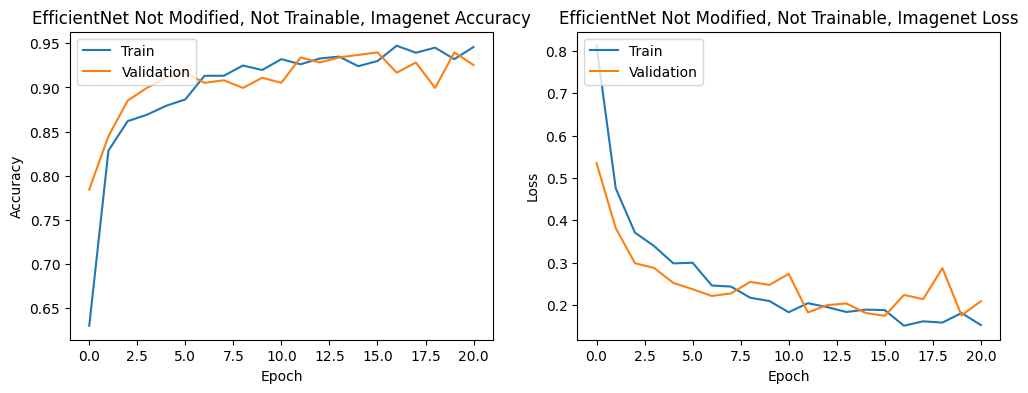

79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9300 - loss: 0.4142

2024-10-24 20:11:18.346387: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7565', 4 bytes spill stores, 4 bytes spill loads

2024-10-24 20:11:18.582040: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7565', 4 bytes spill stores, 4 bytes spill loads

2024-10-24 20:11:18.684126: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7565', 4 bytes spill stores, 4 bytes spill loads

E0000 00:00:1729800684.950641  366978 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729800685.228699  366978 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-

80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 570ms/step - accuracy: 0.9262 - loss: 0.4339
Test Accuracy: 0.7741
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 393ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.83      0.98      0.90      1645
        rust       0.75      0.01      0.02       275
        scab       0.59      0.56      0.57       630

    accuracy                           0.77      2550
   macro avg       0.72      0.52      0.50      2550
weighted avg       0.76      0.77      0.73      2550



In [39]:
model_name = 'EfficientNetB7'
title = "EfficientNet Not Modified, Not Trainable, Imagenet"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_not_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

## Training menggunakan EfficientNet Not Modified 50% Freeze Weights imagenet

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-24 20:14:17.808205: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,19,19,640]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,19,19,2560]{3,2,1,0}, f16[640,1,1,2560]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-24 20:14:17.898233: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.090134067s
Trying algorithm eng0{} for conv (f16[32,19,19,640]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,19,19,2560]{3,2,1,0}, f16[640,1,1,2560]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_

 2/44 ━━━━━━━━━━━━━━━━━━━━ 22s 539ms/step - accuracy: 0.2891 - loss: 1.6508   

2024-10-24 20:17:06.786677: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_39', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_35', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_11__8', 960 bytes spill stores, 788 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3538 - loss: 1.6054

2024-10-24 20:18:52.063310: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7617', 24 bytes spill stores, 24 bytes spill loads

2024-10-24 20:18:52.076826: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7604', 12 bytes spill stores, 12 bytes spill loads

2024-10-24 20:18:52.168238: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7617', 4 bytes spill stores, 4 bytes spill loads

2024-10-24 20:18:52.168946: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7604', 4 bytes spill stores, 4 bytes spill loads

2024-10-24 20:19:04.255314: I external/local_xla/xla/stream_exec

44/44 ━━━━━━━━━━━━━━━━━━━━ 401s 5s/step - accuracy: 0.3546 - loss: 1.6030 - val_accuracy: 0.4397 - val_loss: 1.0710
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.4605 - loss: 1.2183 - val_accuracy: 0.4799 - val_loss: 1.0113
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.6292 - loss: 0.8828 - val_accuracy: 0.6178 - val_loss: 0.8677
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.7132 - loss: 0.7035 - val_accuracy: 0.7960 - val_loss: 0.6792
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7569 - loss: 0.5816 - val_accuracy: 0.8879 - val_loss: 0.5209
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.7980 - loss: 0.4797 - val_accuracy: 0.9080 - val_loss: 0.3965
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8373 - loss: 0.4278 - val_accuracy: 0.9195 - val_loss: 0.3007
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.8533 - loss: 0.3756 - val_accuracy: 0.9310 - val_l

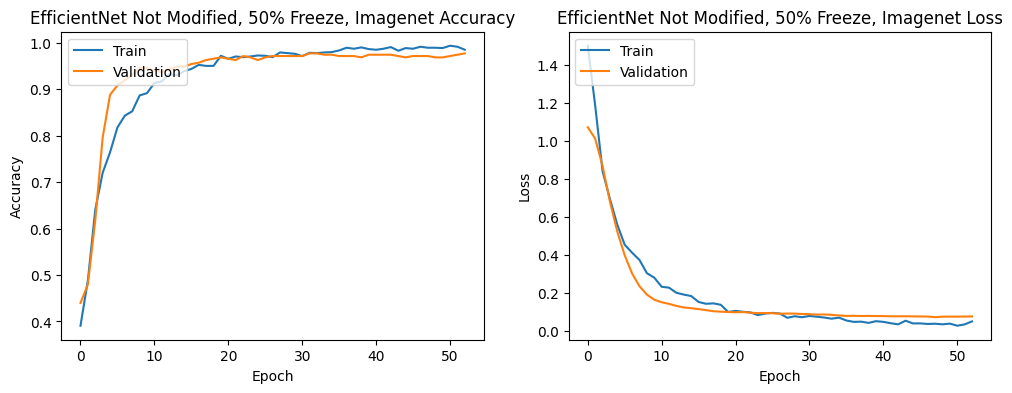

78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9248 - loss: 0.2825

2024-10-24 21:51:40.469552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7604', 12 bytes spill stores, 12 bytes spill loads

2024-10-24 21:51:40.628610: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7617', 4 bytes spill stores, 4 bytes spill loads

2024-10-24 21:51:40.638072: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7604', 4 bytes spill stores, 4 bytes spill loads

2024-10-24 21:51:40.757747: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7604', 4 bytes spill stores, 4 bytes spill loads



80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - accuracy: 0.9209 - loss: 0.2901
Test Accuracy: 0.8200
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 394ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.90      0.96      0.93      1645
        rust       0.84      0.19      0.31       275
        scab       0.62      0.72      0.67       630

    accuracy                           0.82      2550
   macro avg       0.79      0.62      0.64      2550
weighted avg       0.83      0.82      0.80      2550



In [40]:
model_name = 'EfficientNetB7'
title = "EfficientNet Not Modified, 50% Freeze, Imagenet"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

## Training menggunakan EfficientNet Not Modified 0% Freeze Weights None

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


E0000 00:00:1729821620.493631  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729821620.705692  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729821621.748432  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729821621.923932  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729821628.758382  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

  6/173 ━━━━━━━━━━━━━━━━━━━━ 1:26 519ms/step - accuracy: 0.4639 - loss: 1.1988

E0000 00:00:1729821777.284514  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729821777.486325  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729821778.450737  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729821778.623435  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-25 02:03:11.152221: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[192,1,1,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[6,300,300,32]{3,2,1,0}, f16[6

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3547 - loss: 1.9452

2024-10-25 02:06:37.691435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7559', 12 bytes spill stores, 12 bytes spill loads

2024-10-25 02:06:50.908409: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7559', 12 bytes spill stores, 12 bytes spill loads

E0000 00:00:1729822013.068151  518275 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729822013.258495  518275 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


173/173 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.3548 - loss: 1.9429 - val_accuracy: 0.2931 - val_loss: 1.3238
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 111s 641ms/step - accuracy: 0.3544 - loss: 1.1172 - val_accuracy: 0.3592 - val_loss: 1.0999
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 105s 604ms/step - accuracy: 0.3652 - loss: 1.0961 - val_accuracy: 0.3420 - val_loss: 1.2496
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 113s 653ms/step - accuracy: 0.3257 - loss: 1.1035 - val_accuracy: 0.3621 - val_loss: nan
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 106s 610ms/step - accuracy: 0.3739 - loss: 1.0995 - val_accuracy: 0.3563 - val_loss: 1.0942
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 103s 592ms/step - accuracy: 0.3518 - loss: 1.0973 - val_accuracy: 0.3391 - val_loss: 1.0961
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 103s 595ms/step - accuracy: 0.3563 - loss: 1.0960 - val_accuracy: 0.3592 - val_loss: 1.0959
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 102s 589ms/step - accuracy: 0.3505 - loss: 1.0

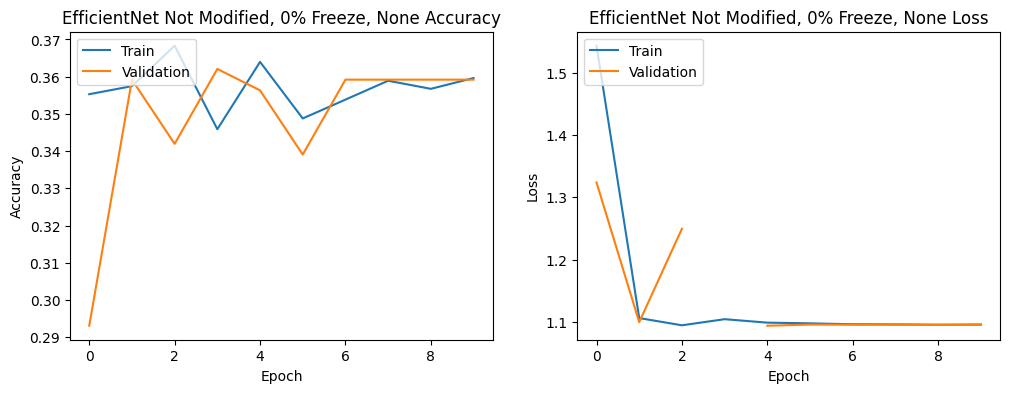

318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0506 - loss: 1.1674

2024-10-25 02:23:26.177856: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7559', 12 bytes spill stores, 12 bytes spill loads



319/319 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - accuracy: 0.0510 - loss: 1.1672
Test Accuracy: 0.1149
319/319 ━━━━━━━━━━━━━━━━━━━━ 51s 107ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.41      0.01      0.02      1645
        rust       0.11      1.00      0.20       275
        scab       0.00      0.00      0.00       630

    accuracy                           0.11      2550
   macro avg       0.17      0.34      0.07      2550
weighted avg       0.28      0.11      0.04      2550



/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [30]:
model_name = 'EfficientNetB7'
title = "EfficientNet Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=8,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size = 8, model.count_params(),GPU_NAME)

## Training menggunakan EfficientNet Not Modified 0% Freeze Weights None (B0-B7)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.3619 - loss: 1.4705 - val_accuracy: 0.3420 - val_loss: 1.1044
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 610ms/step - accuracy: 0.3650 - loss: 1.4661 - val_accuracy: 0.3420 - val_loss: 1.0999
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 642ms/step - accuracy: 0.3740 - loss: 1.5289 - val_accuracy: 0.3592 - val_loss: 1.1014
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 631ms/step - accuracy: 0.4022 - loss: 1.4926 - val_accuracy: 0.3420 - val_loss: 1.1083
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 603ms/step - accuracy: 0.3425 - loss: 1.5806 - val_accuracy: 0.3592 - val_loss: 1.0982
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 610ms/step - accuracy: 0.3800 - loss: 1.4265 - val_accuracy: 0.3592 - val_loss: 1.0956
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 627ms/step - accuracy: 0.3955 - loss: 1.4518 - val_acc

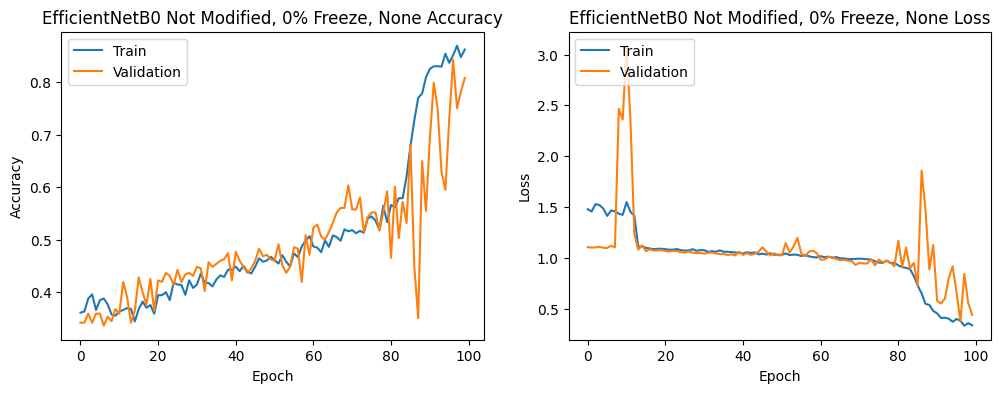

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8769 - loss: 0.4934
Test Accuracy: 0.7416
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.84      0.92      0.88      1645
        rust       0.73      0.17      0.28       275
        scab       0.48      0.52      0.50       630

    accuracy                           0.74      2550
   macro avg       0.69      0.54      0.55      2550
weighted avg       0.74      0.74      0.72      2550



In [34]:
model_name = 'EfficientNetB0'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME,)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.3982 - loss: 1.4832 - val_accuracy: 0.3420 - val_loss: 1.1037
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 673ms/step - accuracy: 0.4161 - loss: 1.4426 - val_accuracy: 0.3420 - val_loss: 1.1088
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 656ms/step - accuracy: 0.3752 - loss: 1.4060 - val_accuracy: 0.3420 - val_loss: 1.1981
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 721ms/step - accuracy: 0.3863 - loss: 1.3021 - val_accuracy: 0.3592 - val_loss: 1.1002
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 675ms/step - accuracy: 0.3901 - loss: 1.2534 - val_accuracy: 0.3420 - val_loss: 1.1572
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 669ms/step - accuracy: 0.3746 - loss: 1.4269 - val_accuracy: 0.3420 - val_loss: 1.1000
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 651ms/step - accuracy: 0.4075 - loss: 1.3069 - val_accuracy: 0.3592 - val_loss: 1.1243
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 659ms/step - accuracy: 0.4341 - loss: 1.2583 - va

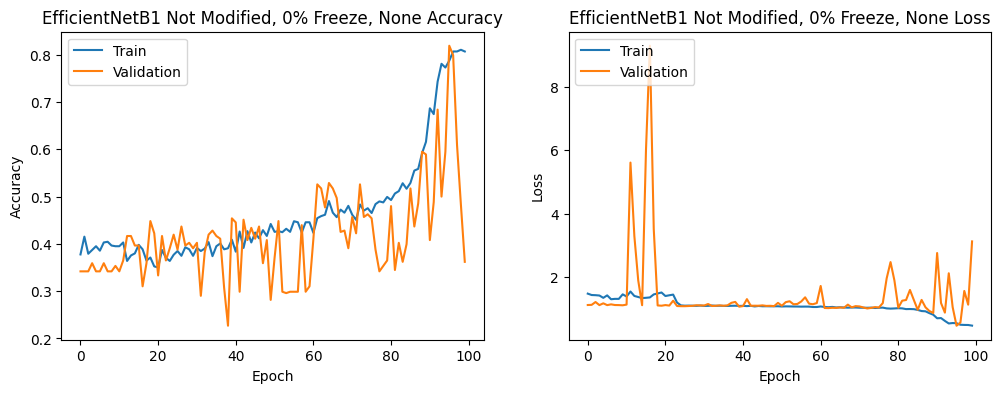

80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.0443 - loss: 2.1593
Test Accuracy: 0.1145
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.26      0.01      0.01      1645
        rust       0.10      0.94      0.19       275
        scab       0.66      0.04      0.07       630

    accuracy                           0.11      2550
   macro avg       0.34      0.33      0.09      2550
weighted avg       0.34      0.11      0.05      2550



In [35]:
model_name = 'EfficientNetB1'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-25 04:17:31.724427: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_89', 4 bytes spill stores, 4 bytes spill loads



27/44 ━━━━━━━━━━━━━━━━━━━━ 10s 633ms/step - accuracy: 0.3202 - loss: 1.5067

2024-10-25 04:18:44.896285: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_97', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3263 - loss: 1.5264

2024-10-25 04:19:00.640072: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3237', 4 bytes spill stores, 4 bytes spill loads

2024-10-25 04:19:00.862463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3237', 4 bytes spill stores, 4 bytes spill loads

2024-10-25 04:19:08.244747: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3237', 12 bytes spill stores, 12 bytes spill loads

2024-10-25 04:19:08.473156: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3237', 4 bytes spill stores, 4 bytes spill loads

2024-10-25 04:19:08.553787: I external/local_xla/xla/stream_execut

44/44 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.3266 - loss: 1.5263 - val_accuracy: 0.3420 - val_loss: 1.1084
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 692ms/step - accuracy: 0.3938 - loss: 1.3407 - val_accuracy: 0.2989 - val_loss: 11.3012
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 751ms/step - accuracy: 0.3572 - loss: 1.5430 - val_accuracy: 0.3592 - val_loss: 10.3286
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 739ms/step - accuracy: 0.3466 - loss: 1.3227 - val_accuracy: 0.3592 - val_loss: 9.9213
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 783ms/step - accuracy: 0.3265 - loss: 1.1495 - val_accuracy: 0.3879 - val_loss: 1.8316
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 694ms/step - accuracy: 0.3776 - loss: 1.0825 - val_accuracy: 0.3506 - val_loss: 1.5727
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 732ms/step - accuracy: 0.4146 - loss: 1.0711 - val_accuracy: 0.3448 - val_loss: 1.1230
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 721ms/step - accuracy: 0.4134 - loss: 1.0800 - val_accuracy

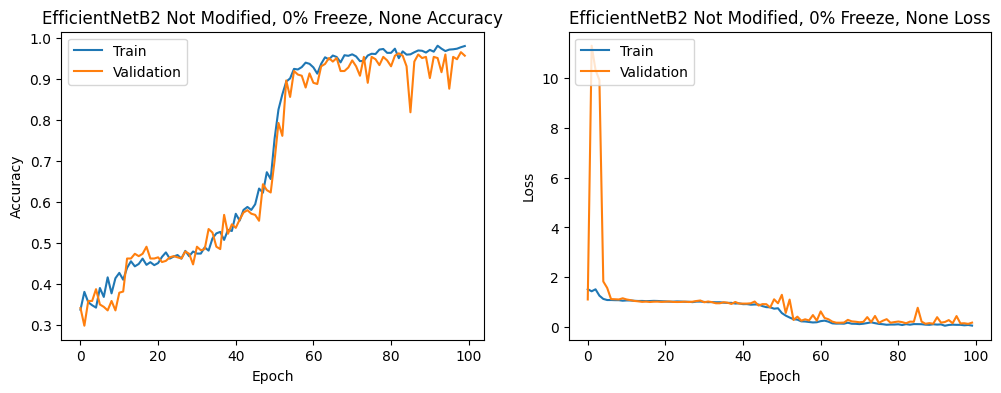

79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9490 - loss: 0.3793

2024-10-25 05:12:43.143825: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3237', 12 bytes spill stores, 12 bytes spill loads

2024-10-25 05:12:43.301695: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3237', 4 bytes spill stores, 4 bytes spill loads



80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9451 - loss: 0.4017
Test Accuracy: 0.7918
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.85      1.00      0.92      1645
        rust       1.00      0.08      0.15       275
        scab       0.59      0.56      0.57       630

    accuracy                           0.79      2550
   macro avg       0.81      0.55      0.55      2550
weighted avg       0.80      0.79      0.75      2550



In [36]:
model_name = 'EfficientNetB2'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.3790 - loss: 1.6286 - val_accuracy: 0.3420 - val_loss: 1.1218
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 918ms/step - accuracy: 0.3720 - loss: 1.3565 - val_accuracy: 0.3592 - val_loss: 1.1101
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 876ms/step - accuracy: 0.3557 - loss: 1.3690 - val_accuracy: 0.3420 - val_loss: 10.6064
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 862ms/step - accuracy: 0.3559 - loss: 1.6465 - val_accuracy: 0.3592 - val_loss: 10.3286
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 883ms/step - accuracy: 0.3595 - loss: 1.6242 - val_accuracy: 0.3276 - val_loss: 8.9248
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 850ms/step - accuracy: 0.3331 - loss: 1.6617 - val_accuracy: 0.3276 - val_loss: nan
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 895ms/step - accuracy: 0.3393 - loss: 1.4910 - val_accuracy: 0.3218 - val_loss: 2.6403
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 855ms/step - accuracy: 0.3325 - loss: 1.4770 - val

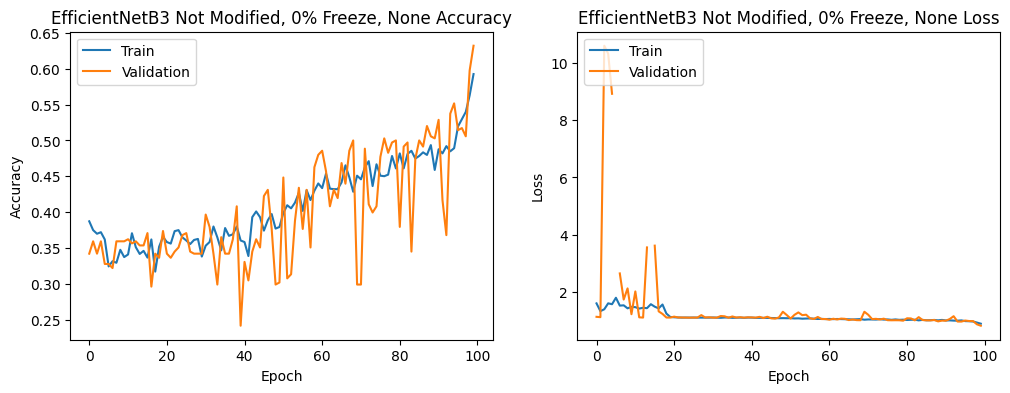

80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.0350 - loss: 1.2736
Test Accuracy: 0.1769
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.00      0.00      0.00      1645
        rust       0.06      0.32      0.11       275
        scab       0.32      0.57      0.41       630

    accuracy                           0.18      2550
   macro avg       0.13      0.30      0.17      2550
weighted avg       0.09      0.18      0.11      2550



In [49]:
model_name = 'EfficientNetB3'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


E0000 00:00:1729838620.584174  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729838620.743442  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729838620.903670  518277 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3680 - loss: 1.5273

2024-10-25 06:47:03.282675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4470', 12 bytes spill stores, 12 bytes spill loads

2024-10-25 06:47:03.444593: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4470', 4 bytes spill stores, 4 bytes spill loads

2024-10-25 06:47:12.089626: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4470', 12 bytes spill stores, 12 bytes spill loads

2024-10-25 06:47:12.230960: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4470', 4 bytes spill stores, 4 bytes spill loads

2024-10-25 06:47:12.251426: I external/local_xla/xla/stream_exec

44/44 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.3678 - loss: 1.5273 - val_accuracy: 0.3420 - val_loss: 1.1053
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3943 - loss: 1.3595 - val_accuracy: 0.3420 - val_loss: 1.0979
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.3629 - loss: 1.5888 - val_accuracy: 0.3592 - val_loss: 1.1049
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3494 - loss: 1.4524 - val_accuracy: 0.3592 - val_loss: 1.1146
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3664 - loss: 1.3026 - val_accuracy: 0.3161 - val_loss: 1.3018
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3665 - loss: 1.1231 - val_accuracy: 0.3046 - val_loss: 1.2303
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.3770 - loss: 1.1003 - val_accuracy: 0.3879 - val_loss: 1.0936
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3560 - loss: 1.0999 - val_accuracy: 0.3678 - val_loss: 1.

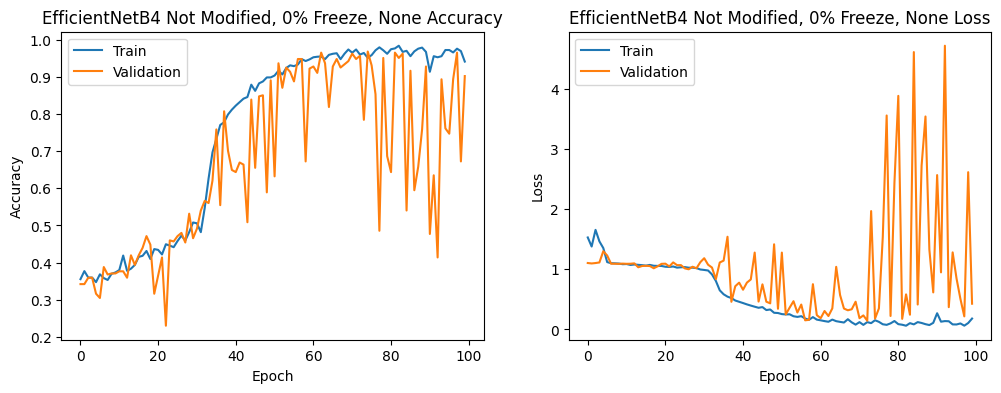

79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9409 - loss: 0.3327

2024-10-25 08:13:15.647633: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4470', 12 bytes spill stores, 12 bytes spill loads

2024-10-25 08:13:15.714932: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4470', 4 bytes spill stores, 4 bytes spill loads

E0000 00:00:1729843998.743442  518276 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729843998.900027  518276 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.9379 - loss: 0.3486
Test Accuracy: 0.8224
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.91      0.99      0.95      1645
        rust       0.37      0.08      0.13       275
        scab       0.63      0.72      0.68       630

    accuracy                           0.82      2550
   macro avg       0.64      0.60      0.58      2550
weighted avg       0.79      0.82      0.79      2550



In [50]:
model_name = 'EfficientNetB4'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 352s 924ms/step - accuracy: 0.3511 - loss: 2.4218 - val_accuracy: 0.3420 - val_loss: 10.6064
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 62s 357ms/step - accuracy: 0.3176 - loss: 2.4992 - val_accuracy: 0.3420 - val_loss: nan
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 68s 393ms/step - accuracy: 0.3185 - loss: 2.4914 - val_accuracy: 0.3534 - val_loss: 1.3029
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 68s 389ms/step - accuracy: 0.3757 - loss: 2.1197 - val_accuracy: 0.3592 - val_loss: 3.9329
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 63s 361ms/step - accuracy: 0.3450 - loss: 3.9226 - val_accuracy: 0.3592 - val_loss: 1.8949
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 63s 361ms/step - accuracy: 0.3737 - loss: 2.1338 - val_accuracy: 0.3276 - val_loss: 4.5574
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 64s 365ms/step - accuracy: 0.3461 - loss: 2

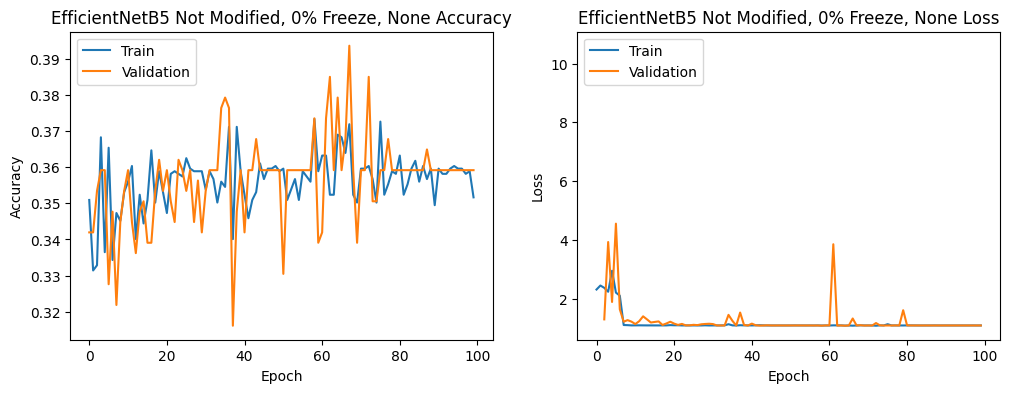

319/319 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.0392 - loss: 1.1998
Test Accuracy: 0.1078
319/319 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.00      0.00      0.00      1645
        rust       0.11      1.00      0.19       275
        scab       0.00      0.00      0.00       630

    accuracy                           0.11      2550
   macro avg       0.04      0.33      0.06      2550
weighted avg       0.01      0.11      0.02      2550



/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [72]:
model_name = 'EfficientNetB5'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=8,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, 8, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.3374 - loss: 2.4608 - val_accuracy: 0.3420 - val_loss: 10.6064
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 81s 465ms/step - accuracy: 0.3417 - loss: 2.6037 - val_accuracy: 0.3420 - val_loss: nan
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 455ms/step - accuracy: 0.3129 - loss: 2.9281 - val_accuracy: 0.3190 - val_loss: 7.5590
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 85s 492ms/step - accuracy: 0.3533 - loss: 2.1335 - val_accuracy: 0.3707 - val_loss: 1.1130
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 454ms/step - accuracy: 0.3368 - loss: 1.1119 - val_accuracy: 0.3563 - val_loss: 1.0958
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 455ms/step - accuracy: 0.3571 - loss: 1.1071 - val_accuracy: 0.3621 - val_loss: 1.0928
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 80s 461ms/step - accuracy: 0.3576 - loss: 1.0998 - val_accuracy: 0.3621 - val_loss: 1.0952
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 80s 459ms/step - accuracy: 0.3598 - los

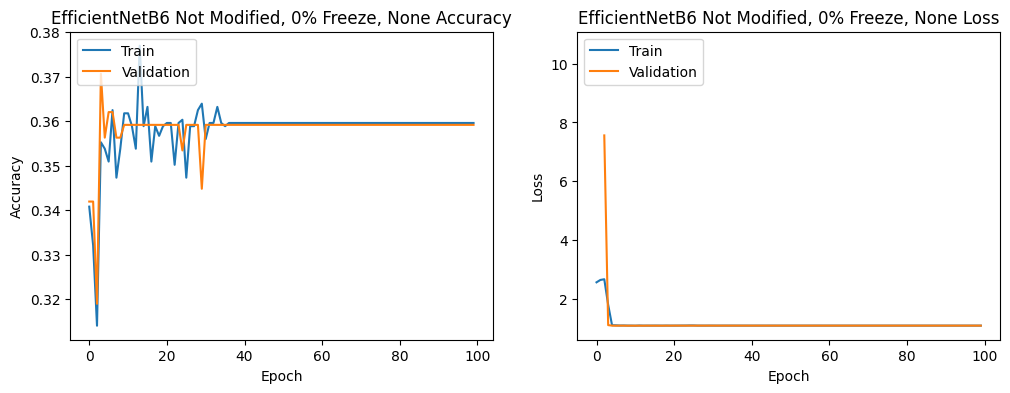

319/319 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.0392 - loss: 1.1972
Test Accuracy: 0.1078
319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.00      0.00      0.00      1645
        rust       0.11      1.00      0.19       275
        scab       0.00      0.00      0.00       630

    accuracy                           0.11      2550
   macro avg       0.04      0.33      0.06      2550
weighted avg       0.01      0.11      0.02      2550



/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [73]:
model_name = 'EfficientNetB6'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=8,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, 8, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


E0000 00:00:1729863926.310369  518278 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729863926.501983  518278 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-25 13:47:04.008866: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_167', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_140', 4 bytes spill stores, 4 bytes spill loads



 87/346 ━━━━━━━━━━━━━━━━━━━━ 1:08 265ms/step - accuracy: 0.3210 - loss: 2.8558

E0000 00:00:1729864087.064339  518276 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729864087.246670  518276 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-25 13:49:37.606330: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_79', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_80', 8 bytes spill stores, 8 bytes spill loads



346/346 ━━━━━━━━━━━━━━━━━━━━ 523s 715ms/step - accuracy: 0.3212 - loss: 3.5632 - val_accuracy: 0.3420 - val_loss: 1.1270
Epoch 2/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 103s 298ms/step - accuracy: 0.3570 - loss: 3.3654 - val_accuracy: 0.3937 - val_loss: nan
Epoch 3/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 95s 273ms/step - accuracy: 0.3536 - loss: 3.4225 - val_accuracy: 0.3937 - val_loss: nan
Epoch 4/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 103s 297ms/step - accuracy: 0.3662 - loss: 3.2450 - val_accuracy: 0.4023 - val_loss: nan
Epoch 5/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 277ms/step - accuracy: 0.3801 - loss: 3.4015 - val_accuracy: 0.3966 - val_loss: 6.5310
Epoch 6/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 276ms/step - accuracy: 0.3572 - loss: 4.2106 - val_accuracy: 0.4023 - val_loss: 2.7274
Epoch 7/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 98s 282ms/step - accuracy: 0.3293 - loss: 1.1174 - val_accuracy: 0.3391 - val_loss: 1.0959
Epoch 8/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 277ms/step - accuracy: 0.3580 - loss: 1.1034 - va

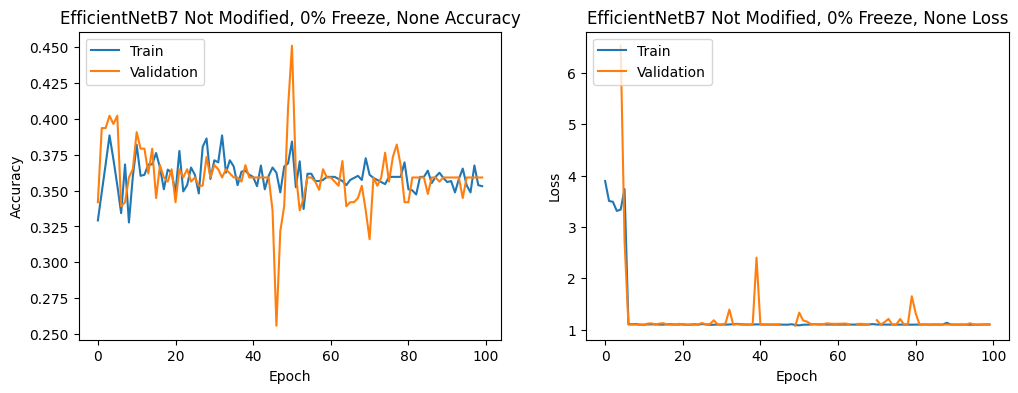

638/638 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.0390 - loss: 1.2149
Test Accuracy: 0.1078
638/638 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

Classification Report:
               precision    recall  f1-score   support

     healthy       0.00      0.00      0.00      1645
        rust       0.11      1.00      0.19       275
        scab       0.00      0.00      0.00       630

    accuracy                           0.11      2550
   macro avg       0.04      0.33      0.06      2550
weighted avg       0.01      0.11      0.02      2550



In [74]:
model_name = 'EfficientNetB7'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=4,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, 4, model.count_params(),GPU_NAME)

# EfficientNet Modified

## Source Code

In [77]:
from utils.efficientNetModifikasi import *
model_parameter()

Model Total Parameters
0  EfficientNetB0        2.606.035
1  EfficientNetB1        4.327.275
2  EfficientNetB2        5.079.523
3  EfficientNetB3        6.063.891
4  EfficientNetB4        8.185.055
5  EfficientNetB5       14.690.923
6  EfficientNetB6       18.689.351
7  EfficientNetB7       29.953.319

## Training menggunakan EfficientNet Modified (B0-B7)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-25 16:32:42.015605: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_50', 4 bytes spill stores, 4 bytes spill loads



31/44 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - accuracy: 0.3686 - loss: 1.4514

2024-10-25 16:33:17.208981: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_46', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.3689 - loss: 1.4357 - val_accuracy: 0.3420 - val_loss: 1.1154
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 642ms/step - accuracy: 0.4133 - loss: 1.0933 - val_accuracy: 0.3592 - val_loss: 1.0952
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - accuracy: 0.4579 - loss: 1.0604 - val_accuracy: 0.2989 - val_loss: 1.4833
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 626ms/step - accuracy: 0.5117 - loss: 0.9805 - val_accuracy: 0.2989 - val_loss: 2.3565
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 621ms/step - accuracy: 0.7170 - loss: 0.6617 - val_accuracy: 0.2989 - val_loss: 3.1577
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 595ms/step - accuracy: 0.7864 - loss: 0.5097 - val_accuracy: 0.2989 - val_loss: 2.2808
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 608ms/step - accuracy: 0.7904 - loss: 0.4610 - val_accuracy: 0.2989 - val_loss: 3.7748
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 595ms/step - accuracy: 0.8454 - loss: 0.3683 - val_accuracy: 0

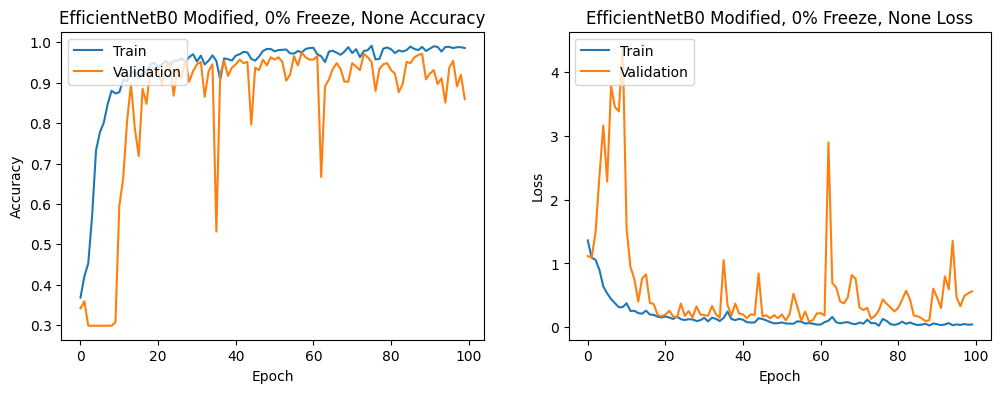

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9560 - loss: 0.1982
Test Accuracy: 0.8447
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.96      0.99      0.97      1645
        rust       0.42      0.59      0.49       275
        scab       0.77      0.59      0.66       630

    accuracy                           0.84      2550
   macro avg       0.72      0.72      0.71      2550
weighted avg       0.86      0.84      0.85      2550



In [78]:
model_name = 'EfficientNetB0'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-25 17:19:22.085855: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_72', 4 bytes spill stores, 4 bytes spill loads



23/44 ━━━━━━━━━━━━━━━━━━━━ 11s 561ms/step - accuracy: 0.3452 - loss: 1.5723

2024-10-25 17:20:04.019896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_64', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.3624 - loss: 1.5409 - val_accuracy: 0.3420 - val_loss: 1.1053
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 663ms/step - accuracy: 0.4188 - loss: 1.3684 - val_accuracy: 0.3420 - val_loss: 1.1565
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 644ms/step - accuracy: 0.3691 - loss: 1.1559 - val_accuracy: 0.3420 - val_loss: 1.1319
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 641ms/step - accuracy: 0.3870 - loss: 1.1026 - val_accuracy: 0.3420 - val_loss: 2.5801
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 657ms/step - accuracy: 0.4752 - loss: 1.0405 - val_accuracy: 0.3420 - val_loss: 1.1726
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 652ms/step - accuracy: 0.4341 - loss: 1.0486 - val_accuracy: 0.3420 - val_loss: 1.4259
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 665ms/step - accuracy: 0.5231 - loss: 0.9994 - val_accuracy: 0.3420 - val_loss: 1.6846
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 661ms/step - accuracy: 0.5830 - loss: 0.8759 - val_accuracy: 

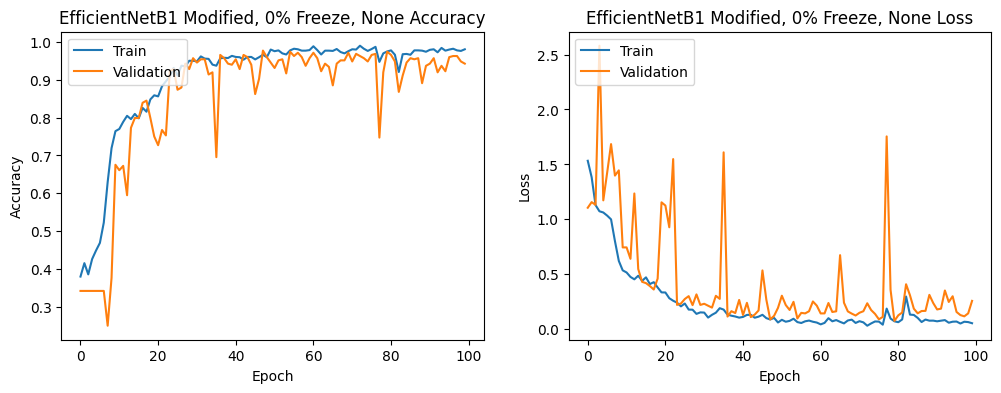

80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9510 - loss: 0.3550
Test Accuracy: 0.8161
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.88      1.00      0.93      1645
        rust       0.83      0.14      0.24       275
        scab       0.63      0.63      0.63       630

    accuracy                           0.82      2550
   macro avg       0.78      0.59      0.60      2550
weighted avg       0.81      0.82      0.79      2550



In [79]:
model_name = 'EfficientNetB1'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-25 18:09:27.019975: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_59', 4 bytes spill stores, 4 bytes spill loads



28/44 ━━━━━━━━━━━━━━━━━━━━ 10s 660ms/step - accuracy: 0.3663 - loss: 1.5937

2024-10-25 18:10:14.879726: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_61', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.3743 - loss: 1.5632 - val_accuracy: 0.3420 - val_loss: 1.1272
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 693ms/step - accuracy: 0.4228 - loss: 1.4711 - val_accuracy: 0.3420 - val_loss: 1.2289
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 736ms/step - accuracy: 0.4713 - loss: 1.2589 - val_accuracy: 0.3448 - val_loss: 1.1024
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 709ms/step - accuracy: 0.6007 - loss: 1.0353 - val_accuracy: 0.3420 - val_loss: 1.3754
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 704ms/step - accuracy: 0.7073 - loss: 0.8365 - val_accuracy: 0.3420 - val_loss: 3.2130
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 742ms/step - accuracy: 0.7056 - loss: 0.6409 - val_accuracy: 0.3736 - val_loss: 2.0726
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 710ms/step - accuracy: 0.7419 - loss: 0.5740 - val_accuracy: 0.3678 - val_loss: 1.9457
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 688ms/step - accuracy: 0.7768 - loss: 0.5110 - val_accuracy: 

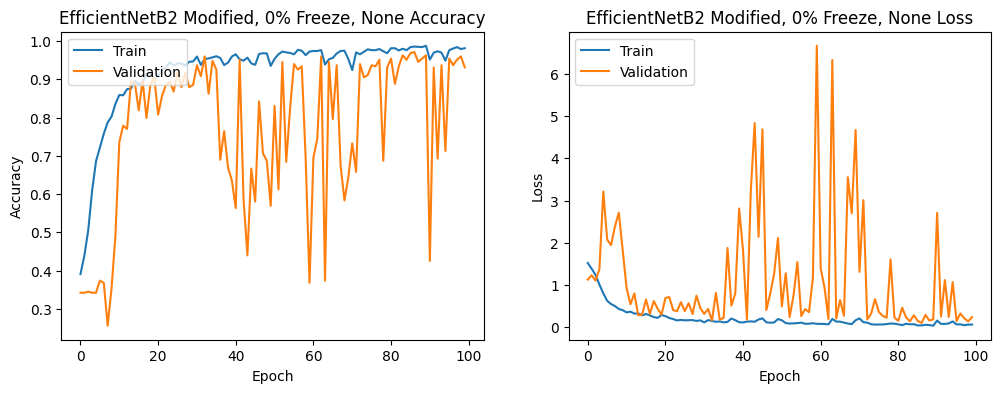

80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.8972 - loss: 0.4012
Test Accuracy: 0.7980
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.98      0.94      0.96      1645
        rust       0.12      0.12      0.12       275
        scab       0.65      0.73      0.69       630

    accuracy                           0.80      2550
   macro avg       0.59      0.60      0.59      2550
weighted avg       0.81      0.80      0.80      2550



In [80]:
model_name = 'EfficientNetB2'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-25 19:04:12.004988: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_70', 4 bytes spill stores, 4 bytes spill loads



22/44 ━━━━━━━━━━━━━━━━━━━━ 16s 729ms/step - accuracy: 0.3583 - loss: 1.6567

2024-10-25 19:04:58.145200: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_72', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3577 - loss: 1.6020 - val_accuracy: 0.2989 - val_loss: 1.1323
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 855ms/step - accuracy: 0.3504 - loss: 1.3959 - val_accuracy: 0.3420 - val_loss: 1.1108
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 865ms/step - accuracy: 0.4067 - loss: 1.1473 - val_accuracy: 0.3592 - val_loss: 1.0999
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 853ms/step - accuracy: 0.4506 - loss: 1.0627 - val_accuracy: 0.3420 - val_loss: 1.1193
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 833ms/step - accuracy: 0.4476 - loss: 1.0669 - val_accuracy: 0.3420 - val_loss: 1.3587
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 850ms/step - accuracy: 0.4621 - loss: 1.0542 - val_accuracy: 0.3420 - val_loss: 1.4190
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 834ms/step - accuracy: 0.4896 - loss: 1.0243 - val_accuracy: 0.3420 - val_loss: 1.2340
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 861ms/step - accuracy: 0.4988 - loss: 1.0355 - val_accuracy: 

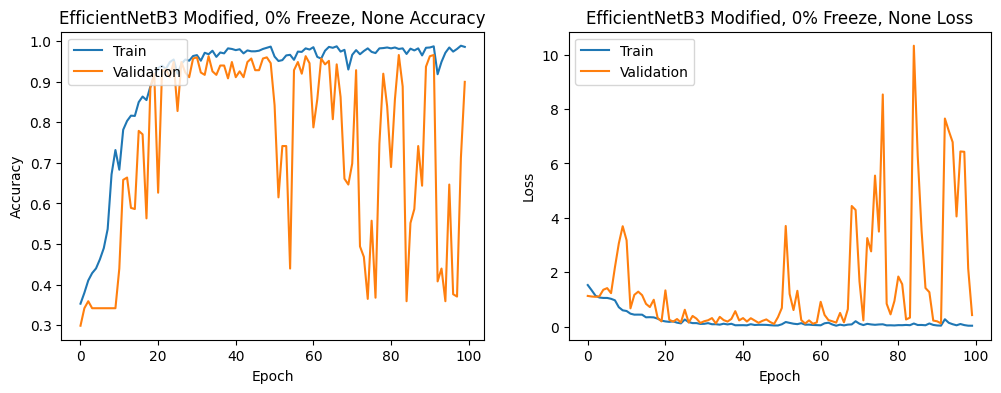

80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.7095 - loss: 1.1403
Test Accuracy: 0.7169
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       1.00      0.73      0.85      1645
        rust       0.05      0.07      0.05       275
        scab       0.64      0.96      0.76       630

    accuracy                           0.72      2550
   macro avg       0.56      0.59      0.55      2550
weighted avg       0.81      0.72      0.74      2550



In [81]:
model_name = 'EfficientNetB3'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-25 20:09:18.867912: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,24,24,2688]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,24,24,448]{3,2,1,0}, f16[2688,1,1,448]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-25 20:09:19.105911: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.23807905s
Trying algorithm eng0{} for conv (f16[32,24,24,2688]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,24,24,448]{3,2,1,0}, f16[2688,1,1,448]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_b

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4110 - loss: 1.4197

2024-10-25 20:11:35.514820: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[28,24,24,2688]{3,2,1,0}, u8[0]{0}) custom-call(f16[28,24,24,448]{3,2,1,0}, f16[2688,1,1,448]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-25 20:11:35.596635: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.08185874s
Trying algorithm eng0{} for conv (f16[28,24,24,2688]{3,2,1,0}, u8[0]{0}) custom-call(f16[28,24,24,448]{3,2,1,0}, f16[2688,1,1,448]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_b

44/44 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.4112 - loss: 1.4184 - val_accuracy: 0.3420 - val_loss: 1.1479
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5996 - loss: 1.1471 - val_accuracy: 0.3420 - val_loss: 3.3829
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6539 - loss: 1.1323 - val_accuracy: 0.2989 - val_loss: 1.6461
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6363 - loss: 0.7245 - val_accuracy: 0.3420 - val_loss: 2.1490
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6831 - loss: 0.5981 - val_accuracy: 0.3420 - val_loss: 2.3011
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7243 - loss: 0.5211 - val_accuracy: 0.3420 - val_loss: 2.8077
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7479 - loss: 0.5219 - val_accuracy: 0.3420 - val_loss: 3.2755
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7691 - loss: 0.4843 - val_accuracy: 0.3420 - val_loss: 1.

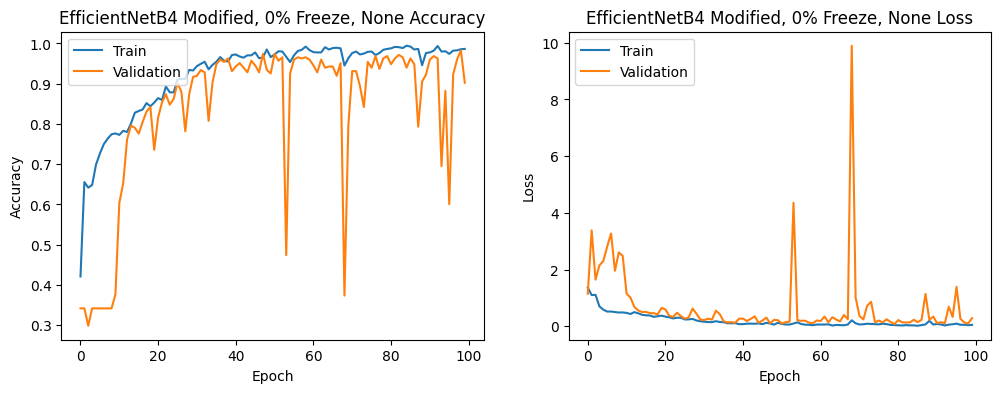

80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.6584 - loss: 1.1503
Test Accuracy: 0.6467
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 409ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.99      0.67      0.80      1645
        rust       0.07      0.19      0.11       275
        scab       0.67      0.78      0.72       630

    accuracy                           0.65      2550
   macro avg       0.58      0.55      0.54      2550
weighted avg       0.81      0.65      0.71      2550



In [82]:
model_name = 'EfficientNetB4'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/100


2024-10-25 22:43:05.592746: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[3072,1,1,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[8,29,29,512]{3,2,1,0}, f16[8,29,29,3072]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-25 22:43:05.778838: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.18615317s
Trying algorithm eng0{} for conv (f16[3072,1,1,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[8,29,29,512]{3,2,1,0}, f16[8,29,29,3072]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cu

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.3878 - loss: 2.3454

2024-10-25 22:45:38.197904: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_81', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_68', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_9__7', 4 bytes spill stores, 4 bytes spill loads



173/173 ━━━━━━━━━━━━━━━━━━━━ 240s 766ms/step - accuracy: 0.3874 - loss: 2.3452 - val_accuracy: 0.3420 - val_loss: 9.0117
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 66s 378ms/step - accuracy: 0.3248 - loss: 2.5581 - val_accuracy: 0.2730 - val_loss: 2.8001
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 66s 379ms/step - accuracy: 0.3605 - loss: 2.3832 - val_accuracy: 0.3506 - val_loss: 6.1376
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 67s 384ms/step - accuracy: 0.3669 - loss: 1.5436 - val_accuracy: 0.3736 - val_loss: 1.0780
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 67s 384ms/step - accuracy: 0.3748 - loss: 1.0936 - val_accuracy: 0.4195 - val_loss: 1.1322
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 64s 370ms/step - accuracy: 0.3623 - loss: 1.1011 - val_accuracy: 0.4454 - val_loss: 1.0730
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 62s 360ms/step - accuracy: 0.3810 - loss: 1.0840 - val_accuracy: 0.4167 - val_loss: 1.0687
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 63s 361ms/step - accuracy: 0.3844 - loss: 1.09

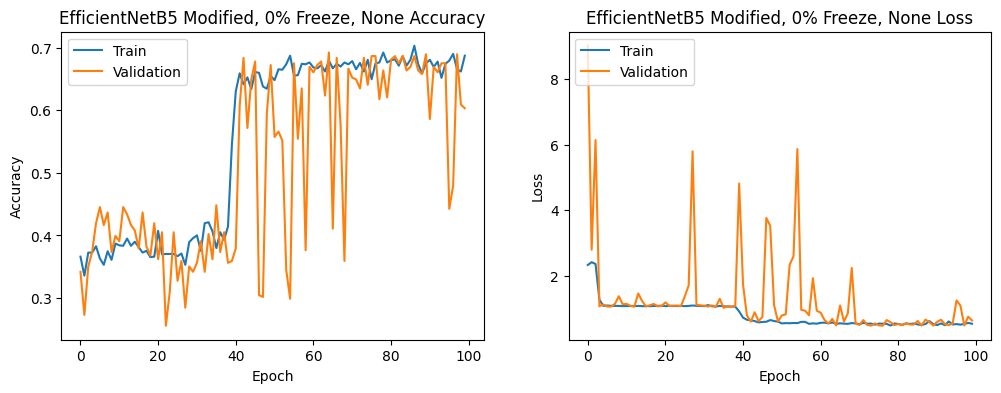

319/319 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9269 - loss: 0.7078
Test Accuracy: 0.6471
319/319 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.66      1.00      0.80      1645
        rust       1.00      0.02      0.04       275
        scab       0.00      0.00      0.00       630

    accuracy                           0.65      2550
   macro avg       0.55      0.34      0.28      2550
weighted avg       0.54      0.65      0.52      2550



In [84]:
model_name = 'EfficientNetB5'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=8,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, 8, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-26 00:31:08.247548: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[576,1,1,2064]{3,2,1,0}, u8[0]{0}) custom-call(f16[8,33,33,2064]{3,2,1,0}, f16[8,33,33,576]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-26 00:31:08.343718: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.096290672s
Trying algorithm eng0{} for conv (f16[576,1,1,2064]{3,2,1,0}, u8[0]{0}) custom-call(f16[8,33,33,2064]{3,2,1,0}, f16[8,33,33,576]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

100/173 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.3821 - loss: 2.3706

2024-10-26 00:33:00.030832: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[3456,1,1,576]{3,2,1,0}, u8[0]{0}) custom-call(f16[6,33,33,576]{3,2,1,0}, f16[6,33,33,3456]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-26 00:33:00.455536: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.42475002s
Trying algorithm eng0{} for conv (f16[3456,1,1,576]{3,2,1,0}, u8[0]{0}) custom-call(f16[6,33,33,576]{3,2,1,0}, f16[6,33,33,3456]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cu

173/173 ━━━━━━━━━━━━━━━━━━━━ 283s 923ms/step - accuracy: 0.3931 - loss: 2.2923 - val_accuracy: 0.3420 - val_loss: 1.1682
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 450ms/step - accuracy: 0.3302 - loss: 2.1657 - val_accuracy: 0.3420 - val_loss: 1.0970
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 451ms/step - accuracy: 0.3574 - loss: 1.1585 - val_accuracy: 0.3420 - val_loss: 1.1505
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 81s 468ms/step - accuracy: 0.3526 - loss: 1.1197 - val_accuracy: 0.3621 - val_loss: 1.1002
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 81s 468ms/step - accuracy: 0.3587 - loss: 1.0924 - val_accuracy: 0.4253 - val_loss: 1.4584
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 81s 468ms/step - accuracy: 0.3647 - loss: 1.1014 - val_accuracy: 0.4339 - val_loss: 1.0876
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 449ms/step - accuracy: 0.3530 - loss: 1.0962 - val_accuracy: 0.4224 - val_loss: 1.4156
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 78s 447ms/step - accuracy: 0.3512 - loss: 1.10

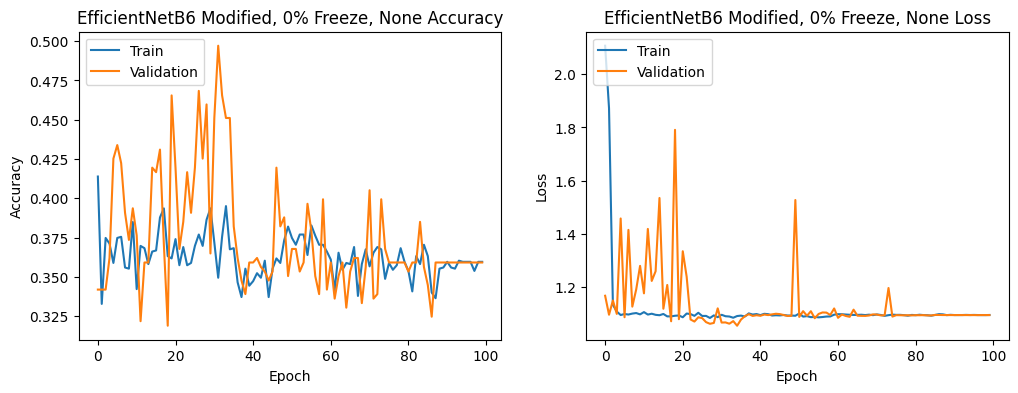

319/319 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.0392 - loss: 1.1975
Test Accuracy: 0.1078
319/319 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.00      0.00      0.00      1645
        rust       0.11      1.00      0.19       275
        scab       0.00      0.00      0.00       630

    accuracy                           0.11      2550
   macro avg       0.04      0.33      0.06      2550
weighted avg       0.01      0.11      0.02      2550



/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [85]:
model_name = 'EfficientNetB6'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=8,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, 8, model.count_params(),GPU_NAME)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/100


2024-10-26 02:47:13.895798: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[640,1,1,2304]{3,2,1,0}, u8[0]{0}) custom-call(f16[4,38,38,2304]{3,2,1,0}, f16[4,38,38,640]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-26 02:47:13.968979: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.073272449s
Trying algorithm eng0{} for conv (f16[640,1,1,2304]{3,2,1,0}, u8[0]{0}) custom-call(f16[4,38,38,2304]{3,2,1,0}, f16[4,38,38,640]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

346/346 ━━━━━━━━━━━━━━━━━━━━ 326s 529ms/step - accuracy: 0.3863 - loss: 2.9202 - val_accuracy: 0.3534 - val_loss: 1.1141
Epoch 2/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 102s 293ms/step - accuracy: 0.3612 - loss: 1.1111 - val_accuracy: 0.3678 - val_loss: 1.3175
Epoch 3/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 102s 293ms/step - accuracy: 0.3355 - loss: 1.1055 - val_accuracy: 0.3707 - val_loss: 1.1607
Epoch 4/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 100s 289ms/step - accuracy: 0.3779 - loss: 1.0927 - val_accuracy: 0.4052 - val_loss: 1.0648
Epoch 5/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 102s 294ms/step - accuracy: 0.3837 - loss: 1.1004 - val_accuracy: 0.4425 - val_loss: 1.0546
Epoch 6/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 97s 279ms/step - accuracy: 0.3565 - loss: 1.1085 - val_accuracy: 0.4195 - val_loss: 1.0618
Epoch 7/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 278ms/step - accuracy: 0.3711 - loss: 1.0935 - val_accuracy: 0.3966 - val_loss: 1.1766
Epoch 8/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 277ms/step - accuracy: 0.3664 - loss: 

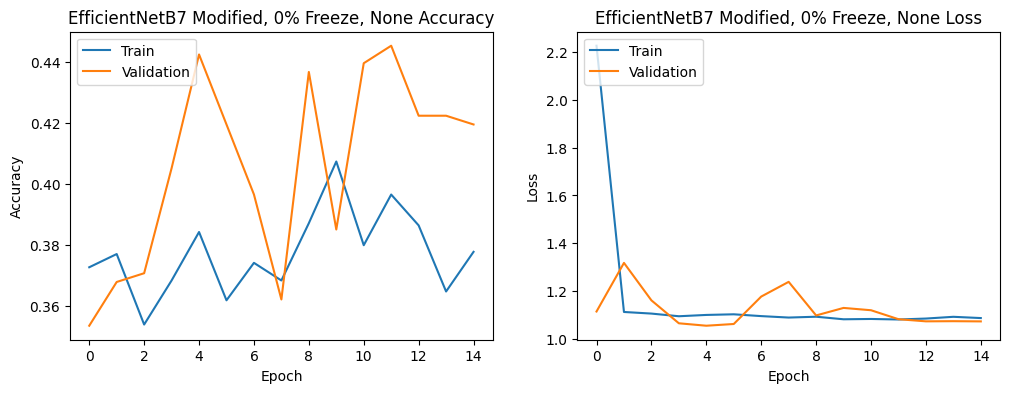

638/638 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.5739 - loss: 1.0380
Test Accuracy: 0.4965
638/638 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.74      0.58      0.65      1645
        rust       0.33      0.85      0.48       275
        scab       0.13      0.11      0.12       630

    accuracy                           0.50      2550
   macro avg       0.40      0.52      0.42      2550
weighted avg       0.55      0.50      0.50      2550



In [88]:
model_name = 'EfficientNetB7'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=4,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, 4, model.count_params(),GPU_NAME)

## Training menggunakan best model EfficientNet modified img size 224 - 600

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3535 - loss: 1.6771 - val_accuracy: 0.3420 - val_loss: 1.1110
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 622ms/step - accuracy: 0.4720 - loss: 1.0717 - val_accuracy: 0.3420 - val_loss: 1.9426
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 601ms/step - accuracy: 0.6435 - loss: 0.7795 - val_accuracy: 0.3420 - val_loss: 2.7883
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 596ms/step - accuracy: 0.7554 - loss: 0.6118 - val_accuracy: 0.3420 - val_loss: 2.5462
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 598ms/step - accuracy: 0.7497 - loss: 0.5666 - val_accuracy: 0.3420 - val_loss: 3.3624
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 630ms/step - accuracy: 0.7848 - loss: 0.5072 - val_accuracy: 0.3420 - val_loss: 2.8265
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 608ms/step - accuracy: 0.8029 - loss: 0.4670 - val_accu

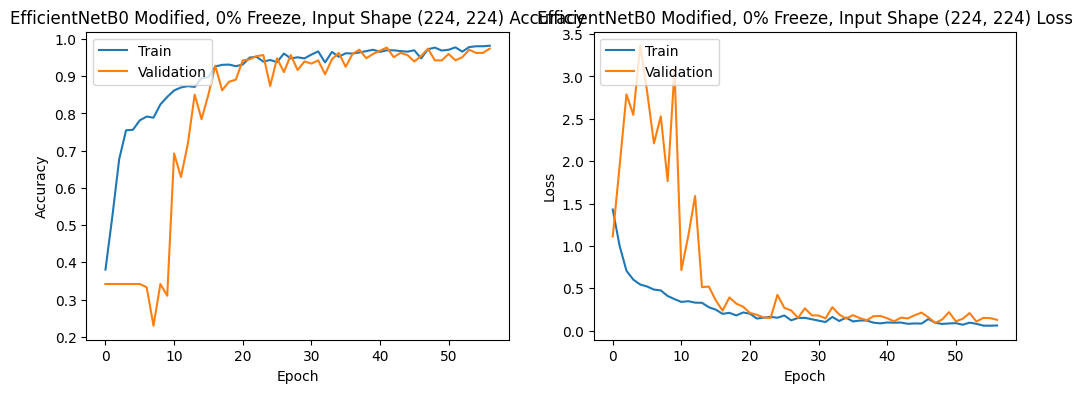

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9343 - loss: 0.4383
Test Accuracy: 0.8569
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.96      0.97      0.97      1645
        rust       1.00      0.06      0.11       275
        scab       0.65      0.90      0.76       630

    accuracy                           0.86      2550
   macro avg       0.87      0.64      0.61      2550
weighted avg       0.89      0.86      0.82      2550

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3921 - loss: 1.5773 - val_accuracy: 0.3420 - val_loss: 1.1352
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 643ms/step - accuracy: 0.4032 - loss: 1.2954 - val_accuracy: 0.3420 - val_loss: 1.1387
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 652ms/step - accuracy: 0.4401 - loss: 1.2407 - val_accuracy: 0.3420 - val_loss: 1.1353
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 661ms/step - accuracy: 0.4269 - loss: 1.0857 - val_accuracy: 0.3420 - val_loss: 1.3314
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 649ms/step - accuracy: 0.4999 - loss: 1.0199 - val_accuracy: 0.3420 - val_loss: 1.2551
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 659ms/step - accuracy: 0.5547 - loss: 0.9616 - val_accuracy: 0.3420 - val_loss: 1.3044
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 652ms/step - accuracy: 0.6673 - loss: 0.7140 - val_accuracy: 0.3420 - val_loss: 1.5826
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 658ms/step - accuracy: 0.7142 - loss: 0.6165 - val

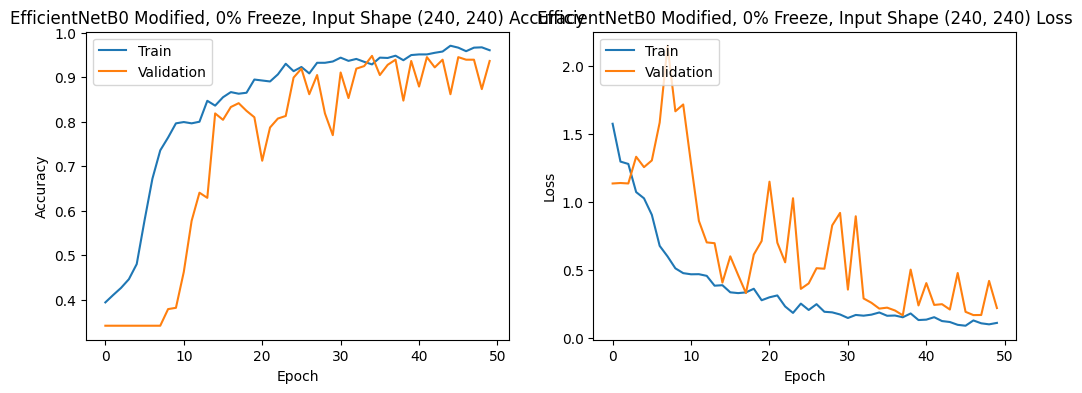

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9360 - loss: 0.5295
Test Accuracy: 0.7357
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.79      1.00      0.88      1645
        rust       0.83      0.07      0.13       275
        scab       0.47      0.34      0.39       630

    accuracy                           0.74      2550
   macro avg       0.70      0.47      0.47      2550
weighted avg       0.72      0.74      0.68      2550

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-26 04:30:37.217723: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_46', 4 bytes spill stores, 4 bytes spill loads



39/44 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step - accuracy: 0.3909 - loss: 1.5272

2024-10-26 04:31:21.582989: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_46', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3899 - loss: 1.5055 - val_accuracy: 0.3420 - val_loss: 1.1657
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 726ms/step - accuracy: 0.4391 - loss: 1.1110 - val_accuracy: 0.3391 - val_loss: 1.1431
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 700ms/step - accuracy: 0.4490 - loss: 1.0722 - val_accuracy: 0.3420 - val_loss: 1.2187
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 720ms/step - accuracy: 0.4621 - loss: 1.0446 - val_accuracy: 0.3420 - val_loss: 1.3632
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 710ms/step - accuracy: 0.5262 - loss: 0.9669 - val_accuracy: 0.2989 - val_loss: 1.6364
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 686ms/step - accuracy: 0.6860 - loss: 0.7192 - val_accuracy: 0.2989 - val_loss: 1.9004
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 700ms/step - accuracy: 0.7979 - loss: 0.5279 - val_accuracy: 0.2989 - val_loss: 5.2647
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 709ms/step - accuracy: 0.8390 - loss: 0.4092 - val_accuracy: 

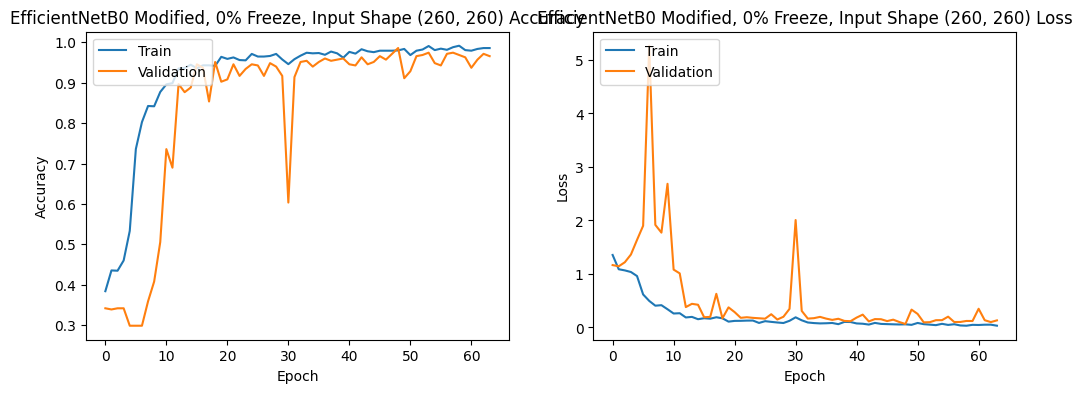

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9490 - loss: 0.4323
Test Accuracy: 0.8243
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.89      1.00      0.94      1645
        rust       1.00      0.05      0.10       275
        scab       0.64      0.71      0.67       630

    accuracy                           0.82      2550
   macro avg       0.84      0.59      0.57      2550
weighted avg       0.84      0.82      0.79      2550

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-26 05:05:30.008544: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_46', 4 bytes spill stores, 4 bytes spill loads



31/44 ━━━━━━━━━━━━━━━━━━━━ 9s 758ms/step - accuracy: 0.3945 - loss: 1.4753 

2024-10-26 05:06:15.141914: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_46', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3914 - loss: 1.4515 - val_accuracy: 0.3420 - val_loss: 1.1575
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 842ms/step - accuracy: 0.5556 - loss: 0.9403 - val_accuracy: 0.3420 - val_loss: 2.0016
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 852ms/step - accuracy: 0.6721 - loss: 0.5972 - val_accuracy: 0.3420 - val_loss: 2.0055
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 807ms/step - accuracy: 0.7545 - loss: 0.5568 - val_accuracy: 0.3420 - val_loss: 2.7238
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 831ms/step - accuracy: 0.7596 - loss: 0.4984 - val_accuracy: 0.3420 - val_loss: 3.2922
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 865ms/step - accuracy: 0.7856 - loss: 0.4750 - val_accuracy: 0.3563 - val_loss: 1.6514
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 831ms/step - accuracy: 0.8049 - loss: 0.4298 - val_accuracy: 0.2960 - val_loss: 2.1286
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 821ms/step - accuracy: 0.8245 - loss: 0.3996 - val_accuracy: 

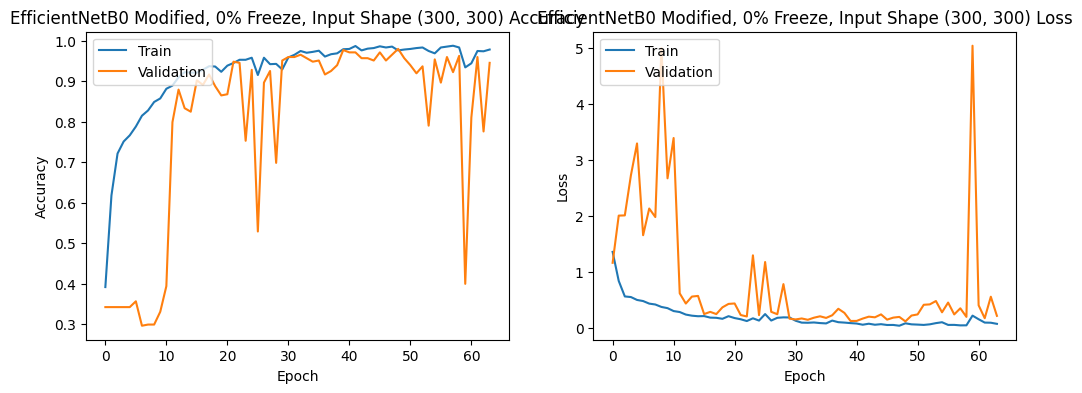

80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.9211 - loss: 0.5242
Test Accuracy: 0.8494
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.95      0.96      0.96      1645
        rust       0.94      0.11      0.20       275
        scab       0.64      0.88      0.74       630

    accuracy                           0.85      2550
   macro avg       0.85      0.65      0.63      2550
weighted avg       0.88      0.85      0.82      2550

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-26 05:46:31.492485: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[1280,1,1,320]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,24,24,320]{3,2,1,0}, f16[32,24,24,1280]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-26 05:46:31.518393: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.026024671s
Trying algorithm eng0{} for conv (f16[1280,1,1,320]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,24,24,320]{3,2,1,0}, f16[32,24,24,1280]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[

42/44 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3964 - loss: 1.4826

2024-10-26 05:47:52.747008: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_52', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.3980 - loss: 1.4777 - val_accuracy: 0.3420 - val_loss: 1.1365
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5015 - loss: 1.0466 - val_accuracy: 0.3420 - val_loss: 1.1183
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7064 - loss: 0.6447 - val_accuracy: 0.3420 - val_loss: 1.3604
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7666 - loss: 0.5553 - val_accuracy: 0.3534 - val_loss: 2.1833
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7975 - loss: 0.4689 - val_accuracy: 0.2989 - val_loss: 2.1822
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8156 - loss: 0.4408 - val_accuracy: 0.2989 - val_loss: 2.7260
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8466 - loss: 0.3768 - val_accuracy: 0.2989 - val_loss: 3.9091
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8597 - loss: 0.3435 - val_accuracy: 0.3190 - val_loss: 2.

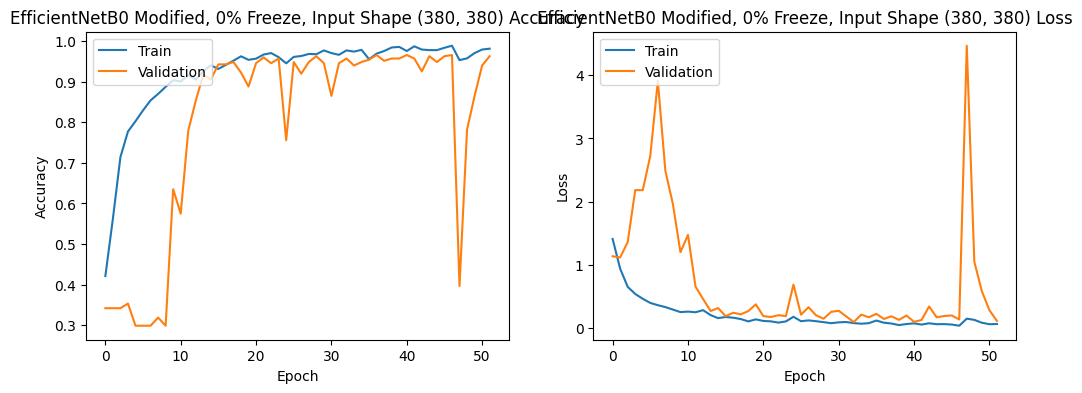

80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.9429 - loss: 0.4397
Test Accuracy: 0.8043
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.86      0.99      0.92      1645
        rust       0.87      0.16      0.28       275
        scab       0.61      0.59      0.60       630

    accuracy                           0.80      2550
   macro avg       0.78      0.58      0.60      2550
weighted avg       0.80      0.80      0.77      2550

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-26 06:32:58.267425: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[320,1,1,1152]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,29,29,1152]{3,2,1,0}, f16[32,29,29,320]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-26 06:32:58.514980: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.247626242s
Trying algorithm eng0{} for conv (f16[320,1,1,1152]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,29,29,1152]{3,2,1,0}, f16[32,29,29,320]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[

42/44 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3428 - loss: 1.4889

2024-10-26 06:34:36.372451: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_52', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.3448 - loss: 1.4778 - val_accuracy: 0.3420 - val_loss: 1.1050
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4450 - loss: 1.0728 - val_accuracy: 0.3420 - val_loss: 1.7090
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7128 - loss: 0.6259 - val_accuracy: 0.3420 - val_loss: 2.9197
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7368 - loss: 0.5750 - val_accuracy: 0.2989 - val_loss: 2.3725
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7988 - loss: 0.4429 - val_accuracy: 0.2989 - val_loss: 1.8393
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8198 - loss: 0.4058 - val_accuracy: 0.2989 - val_loss: 1.9384
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8293 - loss: 0.3677 - val_accuracy: 0.2989 - val_loss: 4.2987
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8672 - loss: 0.3238 - val_accuracy: 0.2989 - val_loss: 2.

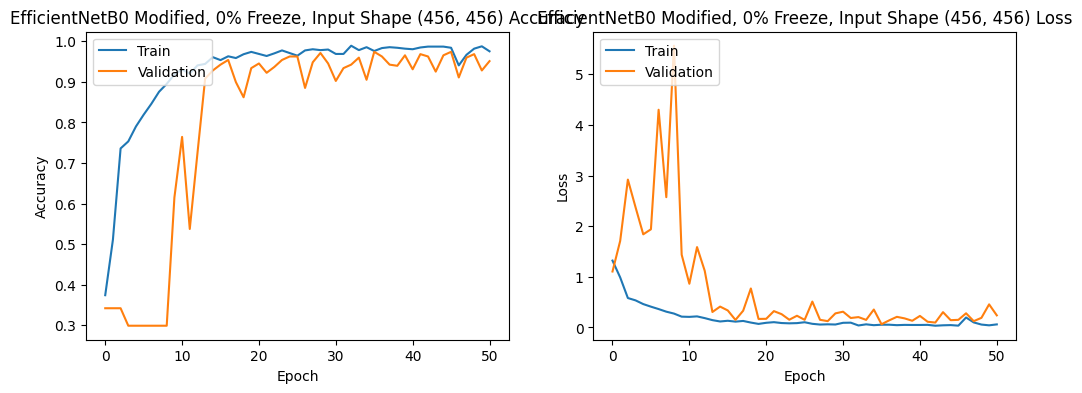

80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.9385 - loss: 0.4548
Test Accuracy: 0.7831
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.84      1.00      0.91      1645
        rust       1.00      0.03      0.06       275
        scab       0.58      0.56      0.57       630

    accuracy                           0.78      2550
   macro avg       0.81      0.53      0.51      2550
weighted avg       0.80      0.78      0.74      2550

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-26 07:31:20.775330: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[320,1,1,1152]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,33,33,1152]{3,2,1,0}, f16[32,33,33,320]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-26 07:31:21.390514: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.615283313s
Trying algorithm eng0{} for conv (f16[320,1,1,1152]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,33,33,1152]{3,2,1,0}, f16[32,33,33,320]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[

 1/44 ━━━━━━━━━━━━━━━━━━━━ 46:24 65s/step - accuracy: 0.2500 - loss: 1.1485

2024-10-26 07:32:02.801928: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_52', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.3619 - loss: 1.5817 - val_accuracy: 0.3420 - val_loss: 1.1117
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4321 - loss: 1.1086 - val_accuracy: 0.3420 - val_loss: 1.2496
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5917 - loss: 0.8914 - val_accuracy: 0.3420 - val_loss: 1.8570
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7474 - loss: 0.5338 - val_accuracy: 0.3420 - val_loss: 1.1749
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7779 - loss: 0.4800 - val_accuracy: 0.3420 - val_loss: 4.0596
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7736 - loss: 0.5331 - val_accuracy: 0.3420 - val_loss: 3.5058
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8137 - loss: 0.4538 - val_accuracy: 0.3621 - val_loss: 2.6701
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8058 - loss: 0.4424 - val_accuracy: 0.2500 - val_loss: 2.

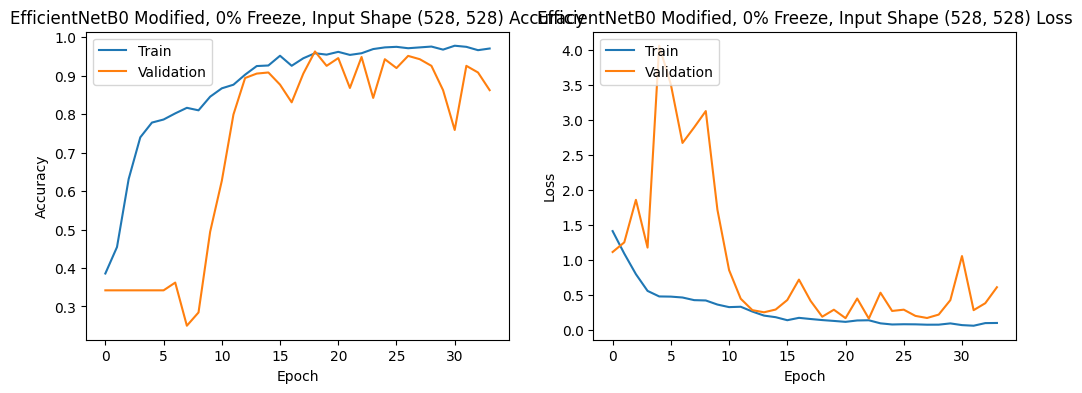

80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - accuracy: 0.9098 - loss: 0.6945
Test Accuracy: 0.7749
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.87      0.96      0.91      1645
        rust       1.00      0.04      0.07       275
        scab       0.54      0.62      0.58       630

    accuracy                           0.77      2550
   macro avg       0.80      0.54      0.52      2550
weighted avg       0.80      0.77      0.74      2550

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-10-26 08:20:32.085741: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,38,38,1280]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,38,38,320]{3,2,1,0}, f16[1280,1,1,320]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-26 08:20:32.208358: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.122663005s
Trying algorithm eng0{} for conv (f16[32,38,38,1280]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,38,38,320]{3,2,1,0}, f16[1280,1,1,320]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_

26/44 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3289 - loss: 1.4812

2024-10-26 08:22:28.826126: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_select_fusion_48', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.3403 - loss: 1.4437 - val_accuracy: 0.3420 - val_loss: 1.1314
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.4035 - loss: 1.0915 - val_accuracy: 0.3420 - val_loss: 1.1432
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4061 - loss: 1.0620 - val_accuracy: 0.3420 - val_loss: 1.1315
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4466 - loss: 1.0183 - val_accuracy: 0.3420 - val_loss: 1.2009
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4711 - loss: 1.0170 - val_accuracy: 0.3420 - val_loss: 1.1814
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4697 - loss: 1.0194 - val_accuracy: 0.3420 - val_loss: 1.1257
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4982 - loss: 0.9799 - val_accuracy: 0.3420 - val_loss: 2.1372
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7236 - loss: 0.6407 - val_accuracy: 0.2845 - val_l

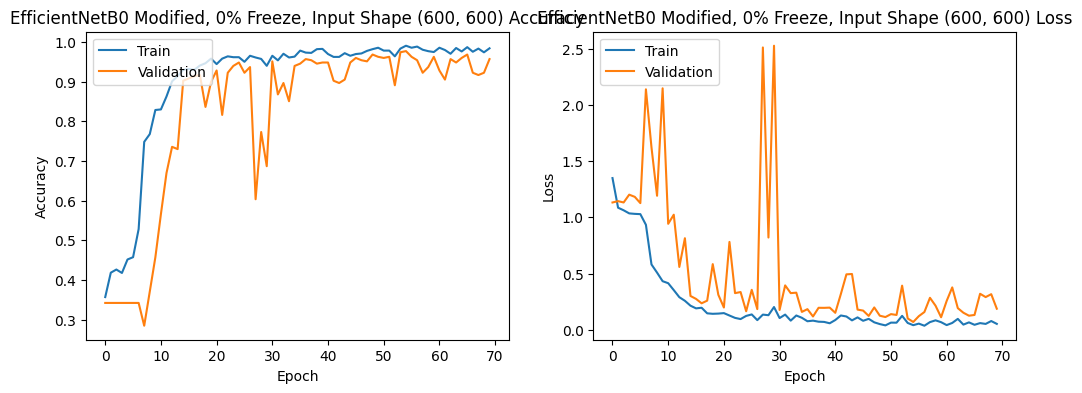

80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 332ms/step - accuracy: 0.9375 - loss: 0.4199
Test Accuracy: 0.7659
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.82      0.99      0.90      1645
        rust       0.97      0.11      0.20       275
        scab       0.55      0.45      0.50       630

    accuracy                           0.77      2550
   macro avg       0.78      0.52      0.53      2550
weighted avg       0.77      0.77      0.72      2550



In [96]:
for img_size in efficientnet_input_shapes.values():
    title = f"EfficientNetB0 Modified, 0% Freeze, Input Shape {img_size}"

    input_shape = (*img_size, 3)

    # Menghasilkan data generator untuk pelatihan, validasi, dan pengujian
    train_generator, validation_generator, test_generator = augment_and_resize_dataset(
        base_path,
        img_size=img_size,
        batch_size=batch_size,
        preprocess_input_func=preprocess_input_func
    )

    # Membangun dan mengkompilasi model dengan input shape yang sesuai
    model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)

    # Melatih model dan menyimpan hasilnya
    history_model, test_loss, test_acc, training_duration = train_and_plot(
        model,
        title,
        train_generator,
        validation_generator,
        test_generator,
        epochs=epochs,
        save_directory=save_directory
    )

    # Menyimpan hasil pelatihan ke file CSV
    store_results(
        title,
        "EfficientNetB0",
        history_model,
        test_loss,
        test_acc,
        training_duration,
        csv_filename,
        img_size,
        batch_size,
        model.count_params(),
        GPU_NAME
    )


## KFold (menggunakan best model img size)

In [175]:
def send_telegram_message(message, image_path=None):
    async def _send_message():
        load_dotenv()
        bot = Bot(token=os.getenv("TELEGRAM_TOKEN"))
        chat_id = os.getenv("TELEGRAM_CHAT_ID")
        
        if image_path:
            with open(image_path, 'rb') as file:
                await bot.send_photo(chat_id=chat_id, photo=file, caption=message)
        else:
            await bot.send_message(chat_id=chat_id, text=message)

    loop = asyncio.get_event_loop()
    loop.run_until_complete(_send_message())


In [176]:
def send_kfold_start_message(model_name, k, img_size, batch_size):
    send_telegram_message(
        "🚀 Starting k-Fold Cross-Validation!\n\n"
        f"Model: {model_name}\n"
        f"Total Folds: {k}\n"
        f"Image Size: {img_size[0]}x{img_size[1]}\n"
        f"Batch Size: {batch_size}\n"
        "⏳ Preparing for training... Each fold will be evaluated and validated.\n"
        "Stay tuned for updates after each fold! 📈"
    )

def send_kfold_end_message(model_name, k, total_duration):
    send_telegram_message(
        f"🎉 **k-Fold Cross-Validation Completed!**\n\n"
        f"Model: {model_name}\n"
        f"Total Folds Completed: {k}\n"
        f"🕒 Total Duration: {total_duration}\n"
        "📊 Check out the final results and plots for performance analysis.\n\n"
        "Thank you for your patience! 🙏"
    )


In [177]:
def send_table_as_image(summary, telegram_message="Hasil k-Fold Cross-Validation"):
    # Buat plot untuk tabel
    fig, ax = plt.subplots(figsize=(8, 4))  # Sesuaikan ukuran gambar
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=summary.values, colLabels=summary.columns, rowLabels=summary.index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Sesuaikan skala tabel

    # Simpan tabel sebagai gambar PNG ke dalam buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)

    # Kirim gambar ke Telegram (gunakan send_telegram_message atau metode lainnya)
    send_telegram_message(telegram_message, image=buf)

In [186]:
from IPython.core.magic import register_line_magic
from IPython.core.interactiveshell import InteractiveShell
import traceback

# Hook untuk menangkap error pada cell
def notify_on_error(shell, traceback, *args):
    # Kirim pesan ke Telegram dengan error message
    send_telegram_message(f"⚠️ Error Detected in Notebook Cell")

# Registrasi hook error
InteractiveShell.instance().set_custom_exc((Exception,), notify_on_error)

In [178]:
def save_fold_results(fold, history, test_loss, test_accuracy, training_duration, precision, recall, f1_score, num_train_images, num_val_images, num_test_images, csv_filename, img_size, batch_size, total_params, GPU_NAME):
    # Konversi durasi pelatihan dari detik ke jam
    training_duration_hours = training_duration / 3600
    
    # Menyimpan akurasi dan loss tertinggi dari history untuk training dan validation
    max_train_acc = max(history.history['accuracy']) if 'accuracy' in history.history else None
    max_val_acc = max(history.history['val_accuracy']) if 'val_accuracy' in history.history else None

    # Menyusun data untuk disimpan ke CSV dengan total_params yang diformat
    data = {
        'Fold': [fold],
        'GPU': [GPU_NAME],
        'Total Parameters': [f"{total_params:,}".replace(",", ".")],
        'Image Size': [img_size],
        'Batch Size': [batch_size],
        'Train Accuracy': [max_train_acc],
        'Train Loss': [min(history.history['loss']) if 'loss' in history.history else None],
        'Validation Accuracy': [max_val_acc],
        'Validation Loss': [min(history.history['val_loss']) if 'val_loss' in history.history else None],
        'Test Accuracy': [test_accuracy],
        'Test Loss': [test_loss],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1_score],
        'Training Duration (seconds)': [round(training_duration)],
        'Training Duration (hours)': [training_duration_hours],
        'Total Epoch': [max(history.epoch) + 1],
        'Train Images': [num_train_images],
        'Validation Images': [num_val_images],
        'Test Images': [num_test_images]
    }

    # Buat DataFrame dari data yang akan disimpan
    results_df = pd.DataFrame(data)

    # Append hasil ke file CSV, jika file belum ada, buat file baru
    file_exists = os.path.isfile(csv_filename)
    results_df.to_csv(csv_filename, mode='a' if file_exists else 'w', header=not file_exists, index=False)

In [179]:
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs, save_directory, fold_num):
    try:
        send_telegram_message(f"Starting training for {model_name}")
        
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
    
        images_save_directory = os.path.join(save_directory, 'images')
        if not os.path.exists(images_save_directory):
            os.makedirs(images_save_directory)
    
        save_path = os.path.join(save_directory, f'best_model_{model_name}.keras')
    
        checkpoint_callback = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, mode='max')
        early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
        
        start_time = time.time()
        
        class TelegramCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                if (epoch + 1) % 10 == 0:
                    msg = (f"Epoch {epoch + 1}/{epochs} - Fold {fold_num}\n"
                           f"Train Accuracy: {logs.get('accuracy'):.4f}, "
                           f"Validation Accuracy: {logs.get('val_accuracy'):.4f}")
                    send_telegram_message(msg)
        
        # Jumlah gambar di setiap set
        num_train_images = train_generator.samples
        num_val_images = validation_generator.samples
        num_test_images = test_generator.samples if test_generator else 0
        
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            callbacks=[checkpoint_callback, early_stopping_callback, TelegramCallback()]
        )
        
        end_time = time.time()
        training_duration = end_time - start_time
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{model_name} Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{model_name} Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    
        plot_path = os.path.join(images_save_directory, f'{model_name}_accuracy_loss.png')
        plt.savefig(plot_path)
        plt.close()

        # Evaluasi pada test_generator
        test_loss, test_accuracy = model.evaluate(test_generator) if test_generator else (None, None)
        
        # Mengambil prediksi dan label asli untuk menghitung Precision, Recall, dan F1-Score
        if test_generator:
            y_pred = np.argmax(model.predict(test_generator), axis=-1)
            y_true = test_generator.classes
            
            # Menghitung metrik Precision, Recall, dan F1-Score
            report = classification_report(y_true, y_pred, output_dict=True)
            precision = report['macro avg']['precision']
            recall = report['macro avg']['recall']
            f1_score = report['macro avg']['f1-score']
        else:
            precision = recall = f1_score = None

        # Konversi training_duration ke format jam:menit:detik
        hours, remainder = divmod(training_duration, 3600)
        minutes, seconds = divmod(remainder, 60)
        
        send_telegram_message(
            f"✅ Training Completed for {model_name}\n"
            f"📊 Fold {fold_num} Results:\n"
            f"🕒 Duration: {int(hours)}h:{int(minutes)}m:{int(seconds)}s\n"
            f"📈 Validation Accuracy: {test_accuracy:.4f}\n"
            f"📊 Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}\n\n"
            f"Images - Train: {num_train_images}, Validation: {num_val_images}, Test: {num_test_images}\n"
            f"Check out the training plot! 📊",
            image_path=plot_path
        )

        return history, test_loss, test_accuracy, training_duration, precision, recall, f1_score, num_train_images, num_val_images, num_test_images
    except Exception as e:
        send_telegram_message(f"Training failed for {model_name}")
        print(f"Error: {e}")
        return None, None, None, None, None, None, None, None, None, None

In [180]:
def kfold_train(base_path, img_size, batch_size, epochs, preprocess_input_func, csv_filename, title, save_directory, test_generator, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    train_path = os.path.join(base_path, 'train')
    class_names = os.listdir(train_path)
    data_paths = []
    labels = []

    # Ambil semua path dan label gambar
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(train_path, class_name)
        for img_file in os.listdir(class_folder):
            data_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_index)
    
    data_paths = np.array(data_paths)
    labels = np.array(labels)

    for fold, (train_idx, val_idx) in enumerate(kf.split(data_paths), start=1):
        # Membagi data menjadi train dan validation berdasarkan indeks KFold
        train_data_paths = data_paths[train_idx]
        train_labels = labels[train_idx].astype(str)
        val_data_paths = data_paths[val_idx]
        val_labels = labels[val_idx].astype(str)

        # Membuat data generator dengan augmentasi untuk train dan tanpa augmentasi untuk validation
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input_func,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

        # Membuat generator data menggunakan flow_from_dataframe untuk kemudahan
        train_generator = train_datagen.flow_from_dataframe(
            pd.DataFrame({'filename': train_data_paths, 'class': train_labels}),
            x_col='filename',
            y_col='class',
            target_size=img_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        validation_generator = validation_datagen.flow_from_dataframe(
            pd.DataFrame({'filename': val_data_paths, 'class': val_labels}),
            x_col='filename',
            y_col='class',
            target_size=img_size,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Bangun model untuk fold ini
        num_classes = len(np.unique(train_labels))  # Mendapatkan jumlah kelas unik dari label
        model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB0, input_shape=(*img_size, 3), num_classes=num_classes)


        # Melatih model dan menyimpan hasil untuk setiap fold
        history, test_loss, test_accuracy, training_duration, precision, recall, f1_score, num_train_images, num_val_images, num_test_images = train_and_plot(
            model, f"{title}_fold_{fold}", train_generator, validation_generator, test_generator, epochs, save_directory, fold_num=fold
        )
        if history is None:
            send_telegram_message(f"Skipping fold {fold} due to an error.")
            print(f"Skipping fold {fold} due to an error.")
            continue  # Lanjut ke fold berikutnya jika ada error pada fold ini

        save_fold_results(
            fold,
            history,
            test_loss,
            test_accuracy,
            training_duration,
            precision,
            recall,
            f1_score,
            num_train_images,
            num_val_images,
            num_test_images,
            csv_filename,
            img_size,
            batch_size,
            total_params=model.count_params(),
            GPU_NAME="GPU_NAME"
        )

In [181]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    test_path = os.path.join(base_path, 'test')

    # Untuk data validation dan test, hanya preprocessing
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator

In [182]:
def evaluate_kfold_results(results_df, csv_filename):
    # Hitung rata-rata dan standar deviasi
    relevant_columns = [
        'Train Accuracy', 'Train Loss',
        'Validation Accuracy', 'Validation Loss',
        'Test Accuracy', 'Test Loss',
        'Precision', 'Recall', 'F1-Score',
        'Training Duration (seconds)'
    ]
    
    # Filter hanya kolom yang relevan dan sesuai urutan
    numeric_cols = results_df[relevant_columns].select_dtypes(include=[np.number])
    summary = numeric_cols.agg(['mean', 'std'])
    
    # Simpan ringkasan hasil ke CSV
    summary.to_csv(csv_filename, index=True)
    return summary

In [183]:
# Set parameter dasar
base_path = "data/split_train_test_dataset_campuran"  # Path ke dataset Anda
img_size = (224, 224)  # Ukuran gambar yang akan digunakan, misal untuk EfficientNetB0
batch_size = 32  # Batch size yang akan digunakan
epochs = 50# Jumlah epoch per fold
title = "EfficientNetB0_(224x224)"
csv_filename = f"outputs/kfold_results_{title}.csv"  # Nama file CSV untuk menyimpan hasil k-fold
save_directory = f"best_model_kFold_{title}/"
k = 5  # Jumlah fold untuk k-fold cross-validation
GPU_NAME = "A100 40GB"
preprocess_input_func = efficientnet_preprocess

send_kfold_start_message(title, k, img_size, batch_size)

start_time_kFold = time.time()

# Jalankan k-fold cross-validation
kfold_train(
    base_path=base_path,
    img_size=img_size,
    batch_size=batch_size,
    epochs=epochs,
    preprocess_input_func=efficientnet_preprocess,
    csv_filename=csv_filename,
    title=title,
    save_directory = save_directory,
    test_generator = augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=preprocess_input_func),
    k=k
)

# Hitung waktu selesai
end_time_kFold = time.time()
total_duration_kFold = end_time - start_time

# Konversi waktu total ke format jam:menit:detik
hours, remainder = divmod(total_duration, 3600)
minutes, seconds = divmod(remainder, 60)
formatted_duration = f"{int(hours)}h:{int(minutes)}m:{int(seconds)}s"

results_df = pd.read_csv(csv_filename)
summary = evaluate_kfold_results(results_df, csv_filename=f"outputs/kfold_{title}_results_summary.csv")
send_table_as_image(summary)

send_kfold_end_message(title, k, formatted_duration)

Found 2550 images belonging to 3 classes.
Found 1105 validated image filenames belonging to 3 classes.
Found 277 validated image filenames belonging to 3 classes.


/root/.local/share/virtualenvs/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitT-NTKd9Xdo/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.3756 - loss: 1.7902 - val_accuracy: 0.3899 - val_loss: 1.1026
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.4248 - loss: 1.1271

KeyboardInterrupt: 

In [ ]:
# Set parameter dasar
base_path = "data/split_train_test_dataset_campuran"  # Path ke dataset Anda
img_size = (300, 300)  # Ukuran gambar yang akan digunakan, misal untuk EfficientNetB0
batch_size = 32  # Batch size yang akan digunakan
epochs = 50# Jumlah epoch per fold
title = "EfficientNetB0_(300x300)"
csv_filename = f"outputs/kfold_results_{title}.csv"  # Nama file CSV untuk menyimpan hasil k-fold
save_directory = f"best_model_kFold_{title}/"
k = 5  # Jumlah fold untuk k-fold cross-validation
GPU_NAME = "A100 40GB"
preprocess_input_func = efficientnet_preprocess

send_kfold_start_message(title, k, img_size, batch_size)

start_time_kFold = time.time()

# Jalankan k-fold cross-validation
kfold_train(
    base_path=base_path,
    img_size=img_size,
    batch_size=batch_size,
    epochs=epochs,
    preprocess_input_func=efficientnet_preprocess,
    csv_filename=csv_filename,
    title=title,
    save_directory = save_directory,
    test_generator = augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=preprocess_input_func),
    k=k
)

# Hitung waktu selesai
end_time_kFold = time.time()
total_duration_kFold = end_time - start_time

# Konversi waktu total ke format jam:menit:detik
hours, remainder = divmod(total_duration, 3600)
minutes, seconds = divmod(remainder, 60)
formatted_duration = f"{int(hours)}h:{int(minutes)}m:{int(seconds)}s"

results_df = pd.read_csv(csv_filename)
summary = evaluate_kfold_results(results_df, csv_filename=f"outputs/kfold_{title}_results_summary.csv")
send_table_as_image(summary)

send_kfold_end_message(title, k, formatted_duration)

In [193]:
from IPython.core.interactiveshell import InteractiveShell
import traceback

# Fungsi untuk mengirim pesan ke bot Telegram
def send_telegram_message(message):
    import requests
    bot_token = '7617783951:AAFVjzaInxzGRLIwzRtt55sykdpocF-6MHA'
    chat_id = '1073241779'
    url = f"https://api.telegram.org/bot{bot_token}/sendMessage"
    payload = {'chat_id': chat_id, 'text': message}
    requests.post(url, data=payload)

# Hook untuk menangkap error pada cell
def notify_on_error(shell, traceback, *args):
    print("Error detected, sending notification...") 
    error_message = ''.join(traceback.format_exception(*args))
    send_telegram_message(f"⚠️ Error Detected in Notebook Cell:\n\n{error_message}")

# Registrasi hook error
InteractiveShell.instance().set_custom_exc((Exception,), notify_on_error)


In [194]:
# IndexError
lst = [1, 2, 3]
print(lst[5])  # Mengakses indeks yang di luar batas list

# NameError
print(undefined_variable)  # Variabel yang tidak didefinisikan

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
    [... skipping hidden 1 frame]

Cell In[194], line 3
      2 lst = [1, 2, 3]
----> 3 print(lst[5])  # Mengakses indeks yang di luar batas list
      5 # NameError

IndexError: list index out of range

During handling of the above exception, another exception occurred:

TypeError                                 Traceback (most recent call last)
TypeError: notify_on_error() got an unexpected keyword argument 'tb_offset'
The original exception:


Custom TB Handler failed, unregistering


In [192]:
send_telegram_message(f"⚠️ Error Detected in Notebook Cell:\n\n")

# ARCHIVE

### B0 GTX 1660 Ti

In [15]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3604 - loss: 1.1083 - val_accuracy: 0.3420 - val_loss: 1.0969
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - accuracy: 0.3913 - loss: 1.0902 - val_accuracy: 0.3420 - val_loss: 1.1001
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 538ms/step - accuracy: 0.4337 - loss: 1.0748 - val_accuracy: 0.3420 - val_loss: 1.1069
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 577ms/step - accuracy: 0.4195 - loss: 1.0688 - val_accuracy: 0.3420 - val_loss: 1.1115
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 547ms/step - accuracy: 0.4335 - loss: 1.0849 - val_accuracy: 0.3420 - val_loss: 1.1194
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 532ms/step - accuracy: 0.3982 - loss: 1.0795 - val_accuracy: 0.3420 - val_loss: 1.1261
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 538ms/step - accuracy: 0.3969 - loss: 1.0697 - val_accuracy: 0.3420 - val_loss: 1.1246
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 541ms/step - accuracy: 0.4297 - loss: 1.0593 - val

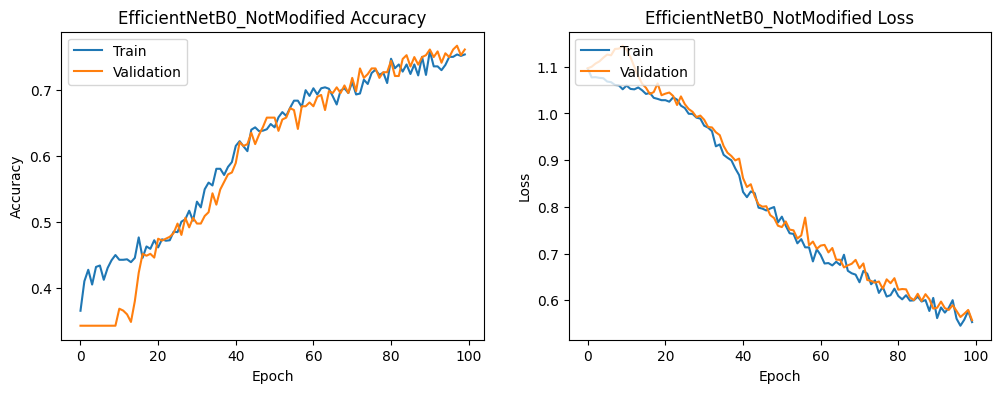

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8287 - loss: 0.6700
Test Accuracy: 0.6549
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.77      0.87      0.82      1645
        rust       0.34      0.16      0.21       275
        scab       0.34      0.30      0.32       630

    accuracy                           0.65      2550
   macro avg       0.48      0.44      0.45      2550
weighted avg       0.62      0.65      0.63      2550



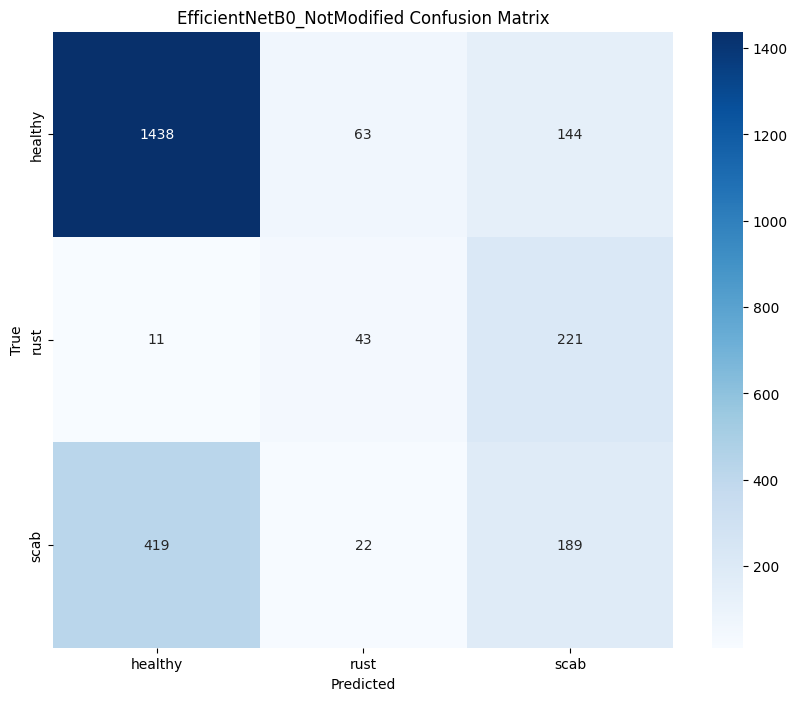

In [16]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=32,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB2(input_shape=(260, 260, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(260, 260, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729658922.538884    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658922.539021    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658922.539071    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658923.092933    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658923.093112    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/100


E0000 00:00:1729659194.722463    7033 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659194.859150    7033 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-23 11:53:23.497346: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[528,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,528,17,17]{3,2,1,0}, f32[8,528,17,17]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=528, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a whi

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3865 - loss: 1.0880

E0000 00:00:1729659266.506627    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.642579    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.779486    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.913482    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659267.089201    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

173/173 ━━━━━━━━━━━━━━━━━━━━ 85s 237ms/step - accuracy: 0.3866 - loss: 1.0880 - val_accuracy: 0.3420 - val_loss: 1.1161
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.4017 - loss: 1.0808 - val_accuracy: 0.3420 - val_loss: 1.1472
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.4253 - loss: 1.0684 - val_accuracy: 0.3621 - val_loss: 1.1147
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.3988 - loss: 1.0734 - val_accuracy: 0.4368 - val_loss: 1.0680
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4126 - loss: 1.0650 - val_accuracy: 0.4655 - val_loss: 1.0523
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.4424 - loss: 1.0537 - val_accuracy: 0.4770 - val_loss: 1.0509
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.4489 - loss: 1.0605 - val_accuracy: 0.4741 - val_loss: 1.0697
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.4350 - loss: 1.053

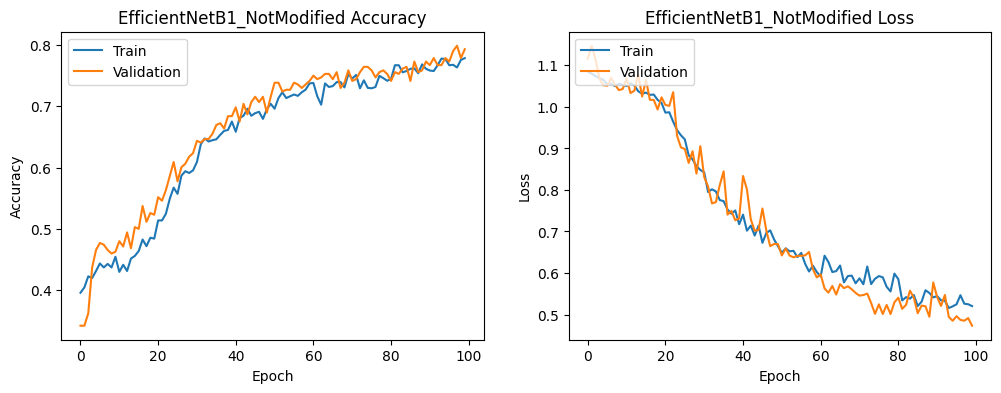

319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8266 - loss: 0.6020
Test Accuracy: 0.6471
319/319 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.76      0.87      0.81      1645
        rust       0.91      0.12      0.21       275
        scab       0.31      0.31      0.31       630

    accuracy                           0.65      2550
   macro avg       0.66      0.43      0.44      2550
weighted avg       0.66      0.65      0.62      2550



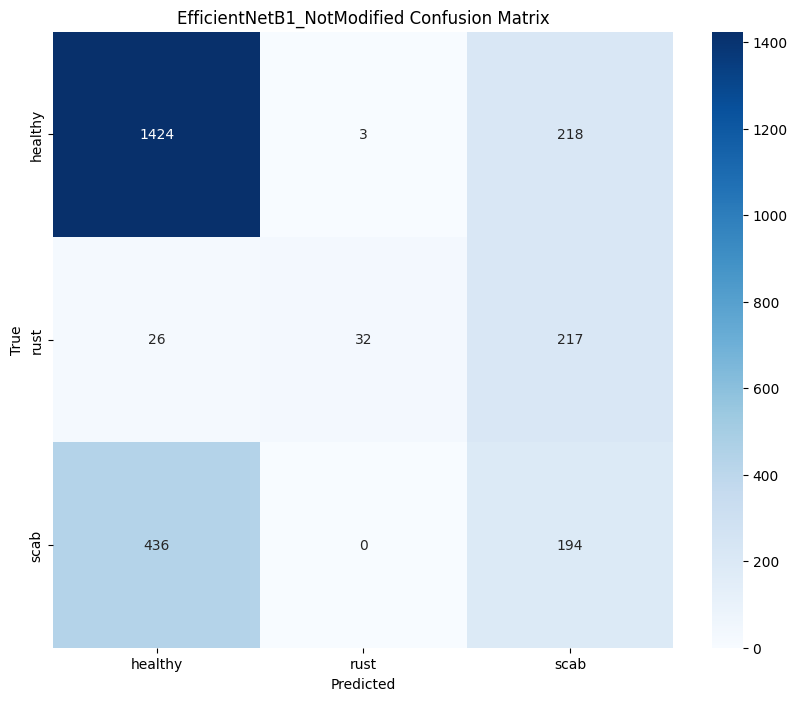

In [9]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(260, 260),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB1_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB3(input_shape=(260, 260, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(260, 260, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729662451.870955   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662451.871094   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662451.871146   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662452.754241   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662452.754362   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


I0000 00:00:1729662481.571014   11594 service.cc:146] XLA service 0x7f7900002be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729662481.571095   11594 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-23 12:48:02.388507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 12:48:05.612672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729662491.217154   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662491.362160   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.3952 - loss: 1.0827

E0000 00:00:1729662552.392563   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662552.539380   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-23 12:49:14.953576: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-23 12:49:15.065619: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more mem

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.3964 - loss: 1.0837

E0000 00:00:1729662610.802106   11596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662610.940417   11596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


173/173 ━━━━━━━━━━━━━━━━━━━━ 160s 500ms/step - accuracy: 0.3963 - loss: 1.0837 - val_accuracy: 0.3420 - val_loss: 1.1119
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.3789 - loss: 1.0902 - val_accuracy: 0.3420 - val_loss: 1.1099
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.4072 - loss: 1.0767 - val_accuracy: 0.3506 - val_loss: 1.1352
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - accuracy: 0.4014 - loss: 1.0721 - val_accuracy: 0.4052 - val_loss: 1.0663
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4337 - loss: 1.0627 - val_accuracy: 0.4109 - val_loss: 1.0962
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.4675 - loss: 1.0454 - val_accuracy: 0.4282 - val_loss: 1.1483
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.4384 - loss: 1.0500 - val_accuracy: 0.4310 - val_loss: 1.2718
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.3995 - loss: 1.08

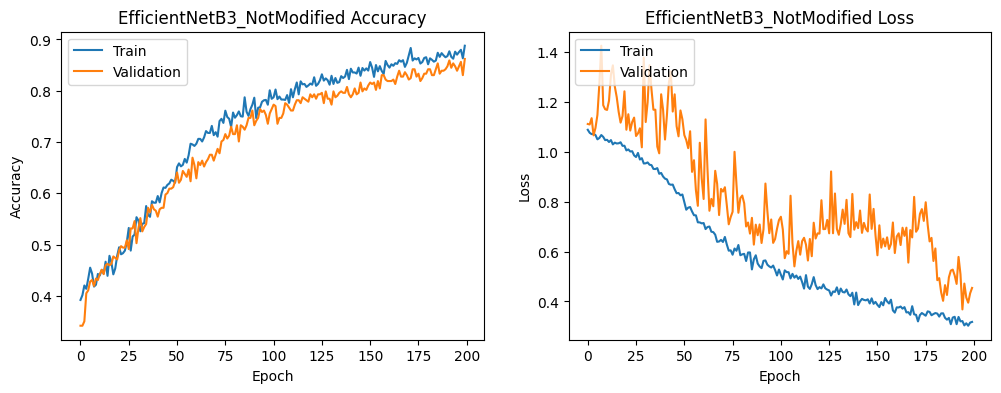

319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7072 - loss: 0.9269
Test Accuracy: 0.5671
319/319 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.73      0.74      0.73      1645
        rust       0.21      0.24      0.22       275
        scab       0.29      0.25      0.27       630

    accuracy                           0.57      2550
   macro avg       0.41      0.41      0.41      2550
weighted avg       0.56      0.57      0.56      2550



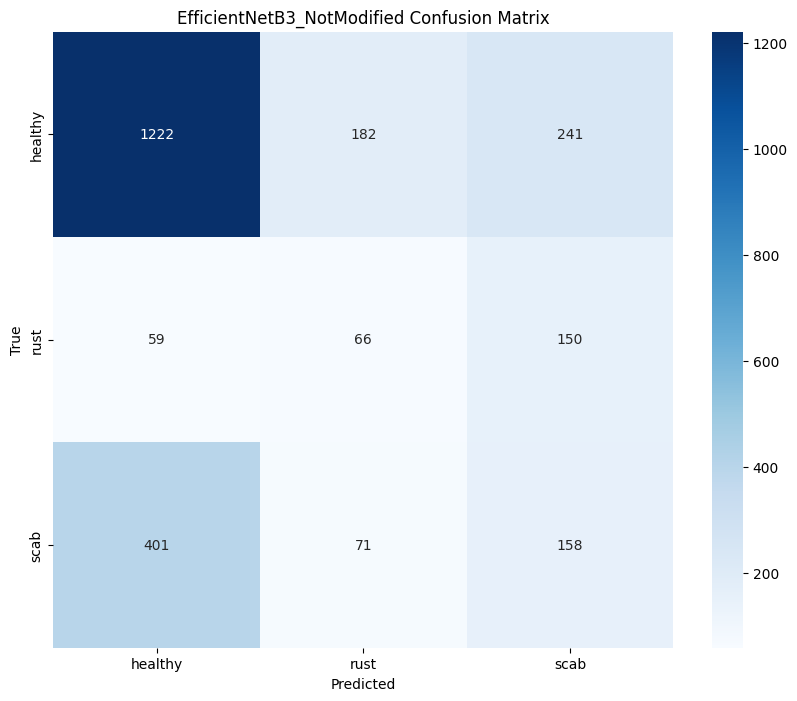

In [8]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(260, 260),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 200
train_and_plot(model, "EfficientNetB3_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB7(input_shape=(300, 300, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(300, 300, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1729675758.068755   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675758.068886   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675758.068931   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675759.911081   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675759.911216   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    27,392,319 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,622,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,541,122 (116.51 MB)

 Trainable params: 30,413,051 (116.02 MB)

 Non-trainable params: 128,071 (500.28 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1729675816.936303   23452 service.cc:146] XLA service 0x7f9db40020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729675816.936384   23452 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-23 16:30:18.716247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 16:30:25.908496: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729675841.255858   23452 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675841.389734   23452 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

188/346 ━━━━━━━━━━━━━━━━━━━━ 28s 180ms/step - accuracy: 0.3931 - loss: 1.1030

E0000 00:00:1729675948.631973   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675948.770451   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675948.906702   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675949.044441   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675949.183319   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

346/346 ━━━━━━━━━━━━━━━━━━━━ 279s 422ms/step - accuracy: 0.3971 - loss: 1.0992 - val_accuracy: 0.3420 - val_loss: 1.1344
Epoch 2/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - accuracy: 0.3846 - loss: 1.0898 - val_accuracy: 0.3851 - val_loss: 1.8298
Epoch 3/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.4233 - loss: 1.0770 - val_accuracy: 0.4368 - val_loss: 3.9750
Epoch 4/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.4299 - loss: 1.0747 - val_accuracy: 0.3736 - val_loss: 3.3302
Epoch 5/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.3808 - loss: 1.0962 - val_accuracy: 0.4023 - val_loss: 2.5894
Epoch 6/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.4307 - loss: 1.0695 - val_accuracy: 0.4195 - val_loss: 4.1685
Epoch 7/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.4002 - loss: 1.0825 - val_accuracy: 0.4454 - val_loss: 2.2188
Epoch 8/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 199ms/step - accuracy: 0.3996 - loss: 1.06

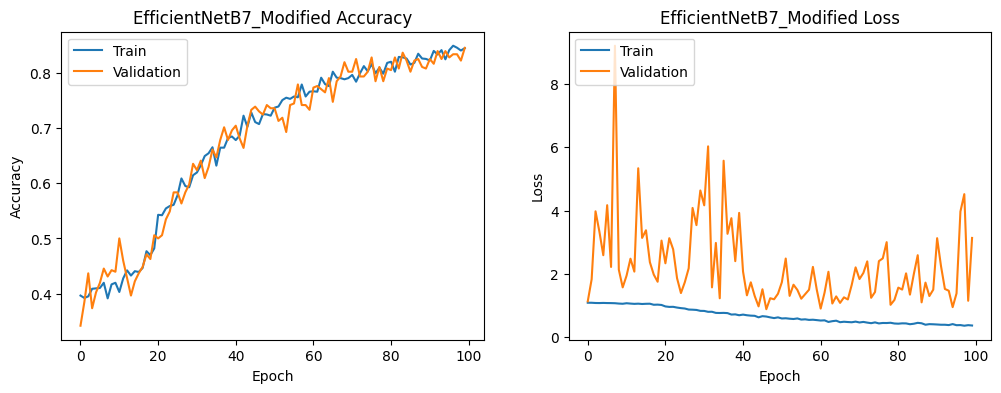

638/638 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.7539 - loss: 6.7549
Test Accuracy: 0.6039
638/638 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.75      0.80      0.77      1645
        rust       0.15      0.22      0.18       275
        scab       0.41      0.27      0.32       630

    accuracy                           0.60      2550
   macro avg       0.44      0.43      0.43      2550
weighted avg       0.60      0.60      0.60      2550



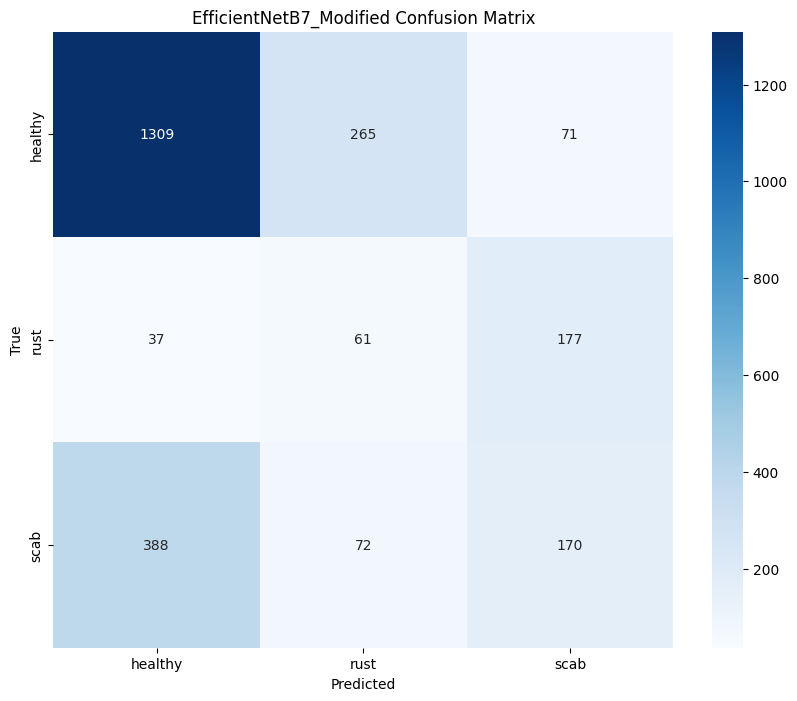

In [8]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(300, 300),
    batch_size=4,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB7_Modified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [12]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot_and_saved(model, model_name, train_generator, validation_generator, test_generator, epochs):
    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs
        # callbacks=[early_stopping_callback]
    )

    model.save('ENB7_MODIFIED_200EPOCHS.keras')

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Tampilkan confusion matrix
    plt.show()

In [13]:
model = EfficientNetB7(input_shape=(300, 300, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(300, 300, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-10-24 11:23:21.643573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14936 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:4e:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    27,392,319 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,622,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,541,122 (116.51 MB)

 Trainable params: 30,413,051 (116.02 MB)

 Non-trainable params: 128,071 (500.28 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.3943 - loss: 1.0891 - val_accuracy: 0.4368 - val_loss: 1.5727
Epoch 2/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.4047 - loss: 1.0890 - val_accuracy: 0.4224 - val_loss: 2.3367
Epoch 3/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.3949 - loss: 1.0831 - val_accuracy: 0.4282 - val_loss: 3.5399
Epoch 4/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.4178 - loss: 1.0721 - val_accuracy: 0.4282 - val_loss: 2.1141
Epoch 5/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - accuracy: 0.4149 - loss: 1.0797 - val_accuracy: 0.4253 - val_loss: 2.2503
Epoch 6/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.4250 - loss: 1.0606 - val_accuracy: 0.4828 - val_loss: 1.2056
Epoch 7/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - accuracy: 0.4323 - loss: 1.0587 - val_accuracy: 0.4483 - val_loss: 2.3049
Epoch 8/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 82s 196ms/step - accuracy: 0.4446 -

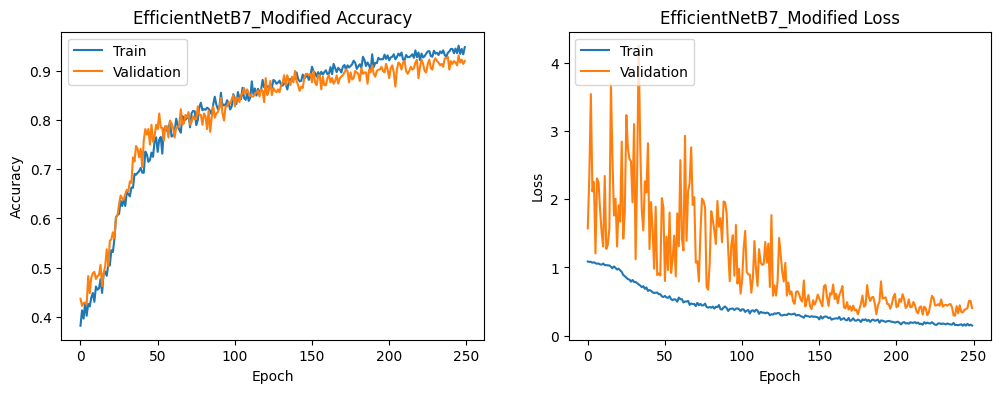

638/638 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.9278 - loss: 0.7204
Test Accuracy: 0.7949
638/638 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.87      0.97      0.91      1645
        rust       0.47      0.13      0.20       275
        scab       0.63      0.64      0.63       630

    accuracy                           0.79      2550
   macro avg       0.65      0.58      0.58      2550
weighted avg       0.76      0.79      0.77      2550



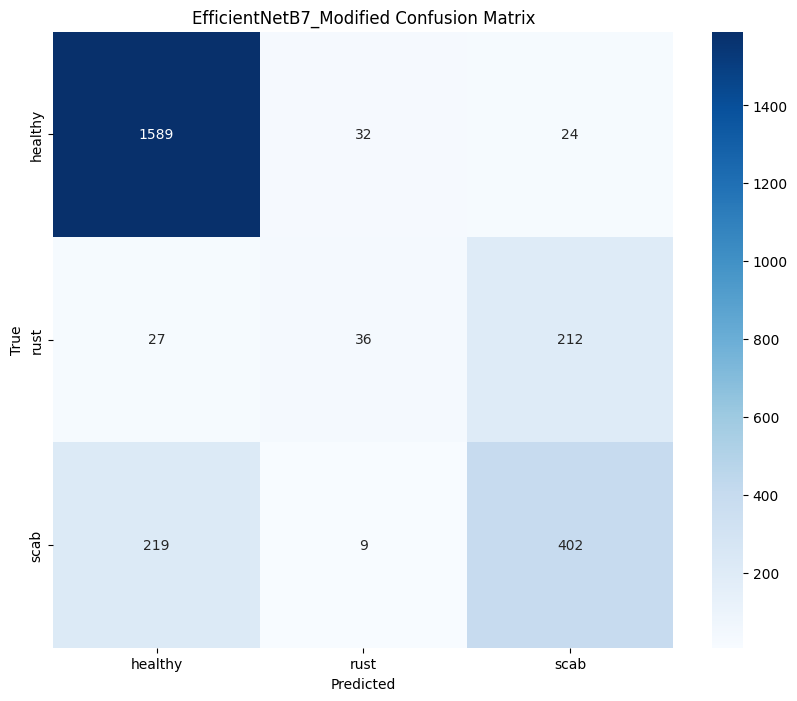

In [13]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(300, 300),
    batch_size=4,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 250
train_and_plot_and_saved(model, "EfficientNetB7_Modified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [8]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
model.trainable = True

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729671865.254654   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671865.254773   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671865.254842   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671866.588226   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671866.588309   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

ValueError: Layer count mismatch when loading weights from file. Model expected 75 layers, found 131 saved layers.

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 759ms/step - accuracy: 0.3001 - loss: 1.7218 - val_accuracy: 0.3592 - val_loss: 1.1188
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.4284 - loss: 1.3337 - val_accuracy: 0.4368 - val_loss: 1.0658
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.4505 - loss: 1.3179 - val_accuracy: 0.5431 - val_loss: 0.9671
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step - accuracy: 0.5163 - loss: 1.1420 - val_accuracy: 0.6149 - val_loss: 0.8798
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - accuracy: 0.5487 - loss: 1.0815 - val_accuracy: 0.6408 - val_loss: 0.8048
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 0.5630 - loss: 0.9987 - val_accuracy: 0.6868 - val_loss: 0.7241
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.6312 - loss: 0.8638 - val_accurac

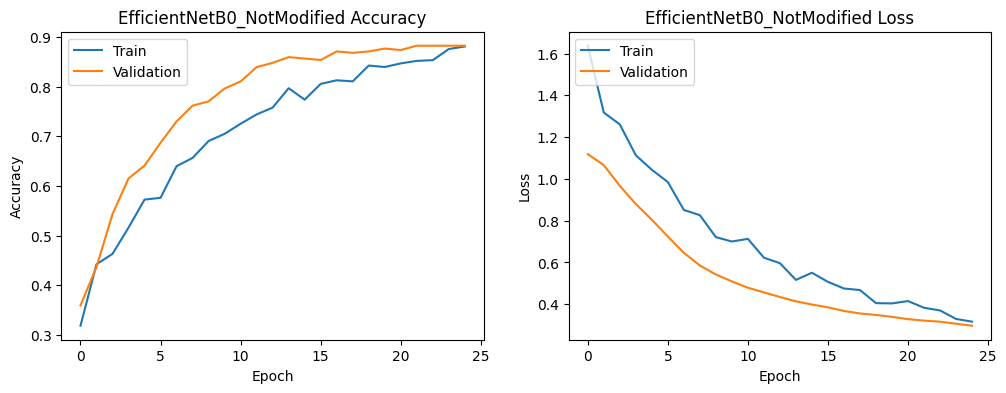

160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5746 - loss: 1.0900
Test Accuracy: 0.5875
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.88      0.59      0.71      1645
        rust       0.85      0.11      0.19       275
        scab       0.35      0.80      0.49       630

    accuracy                           0.59      2550
   macro avg       0.70      0.50      0.46      2550
weighted avg       0.75      0.59      0.60      2550



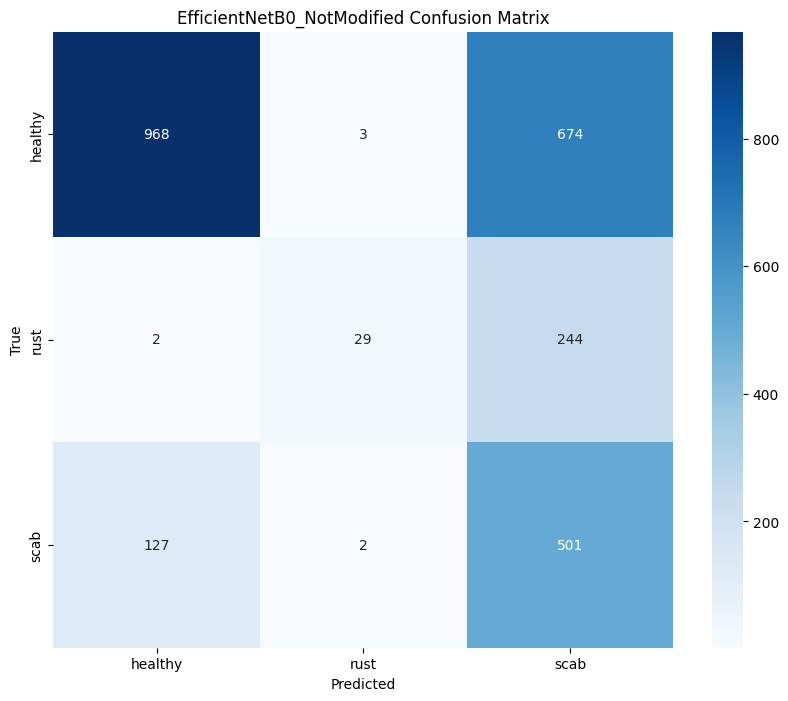

In [12]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 25
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [13]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
model.trainable = True

# Freeze 50% layer pertama dari base model
total_layers = len(model.layers)
freeze_layers = int(0.50 * total_layers)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 100s 641ms/step - accuracy: 0.3196 - loss: 1.6687 - val_accuracy: 0.4339 - val_loss: 1.0649
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - accuracy: 0.4523 - loss: 1.3630 - val_accuracy: 0.4856 - val_loss: 0.9965
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step - accuracy: 0.4826 - loss: 1.2405 - val_accuracy: 0.5661 - val_loss: 0.8999
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.5103 - loss: 1.1727 - val_accuracy: 0.6437 - val_loss: 0.8121
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.5638 - loss: 1.0652 - val_accuracy: 0.6753 - val_loss: 0.7508
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.5669 - loss: 1.0052 - val_accuracy: 0.7098 - val_loss: 0.6822
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.6660 - loss: 0.8715 - val_accuracy: 0.7385 - val_loss: 0.6211
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 0.6688 - loss: 0.8582 - val_acc

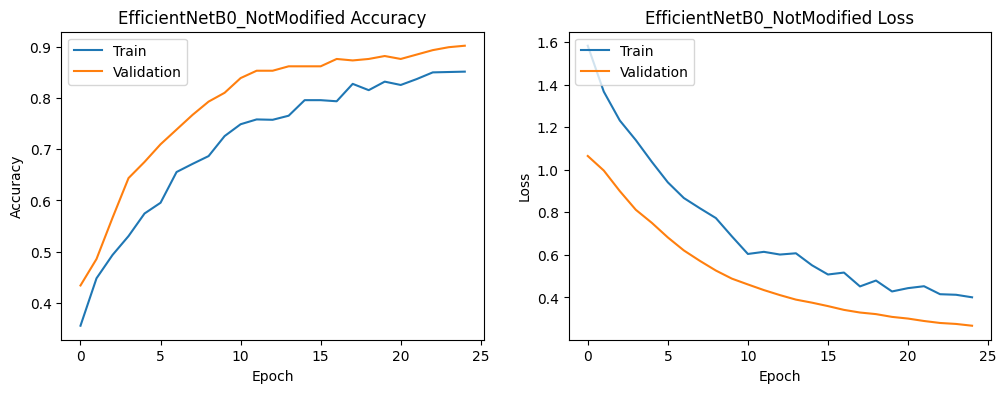

160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8957 - loss: 0.3315
Test Accuracy: 0.7635
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.84      0.93      0.88      1645
        rust       0.64      0.36      0.46       275
        scab       0.55      0.50      0.52       630

    accuracy                           0.76      2550
   macro avg       0.68      0.60      0.62      2550
weighted avg       0.75      0.76      0.75      2550



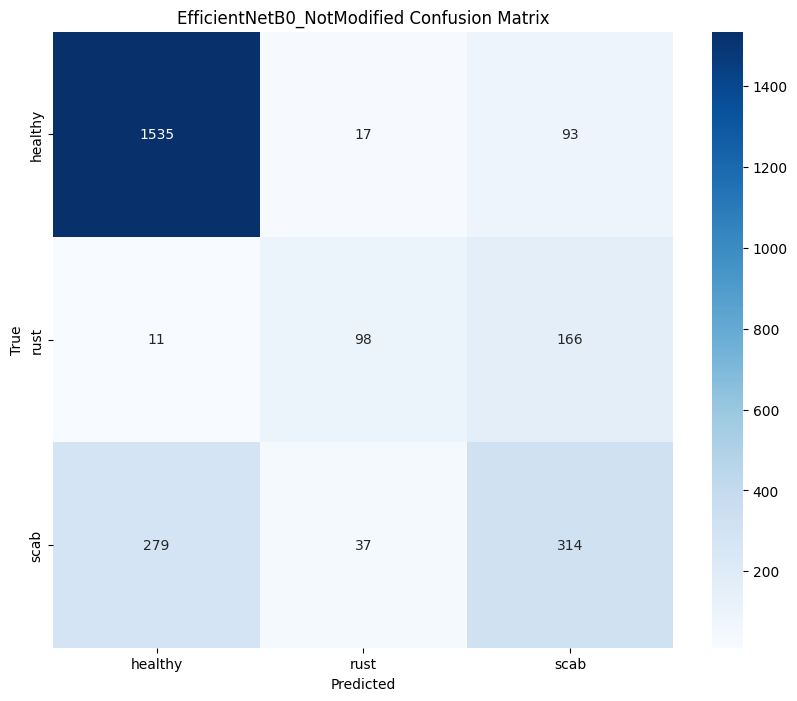

In [14]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 25
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

### B7 RTX 4090

In [10]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    53,618,519 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,319,194 (207.21 MB)

 Trainable params: 54,062,483 (206.23 MB)

 Non-trainable params: 256,711 (1002.78 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.3037 - loss: 1.6199 - val_accuracy: 0.3420 - val_loss: 1.4662
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 92s 528ms/step - accuracy: 0.3418 - loss: 1.4300 - val_accuracy: 0.3420 - val_loss: 1.6476
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 152s 878ms/step - accuracy: 0.3572 - loss: 1.4127 - val_accuracy: 0.3420 - val_loss: 1.6766
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 814ms/step - accuracy: 0.3295 - loss: 1.5060 - val_accuracy: 0.3707 - val_loss: 2.8117
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 518ms/step - accuracy: 0.3423 - loss: 1.3977 - val_accuracy: 0.3678 - val_loss: 9.6644
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 524ms/step - accuracy: 0.3493 - loss: 1.3777 - val_accuracy: 0.3879 - val_loss: 16.2614
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 94s 540ms/step - accuracy: 0.3736 - loss: 1.3454 - val_accuracy: 0.3736 - val_loss: 24.6332
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 517ms/step - accuracy: 0.3793 - loss:

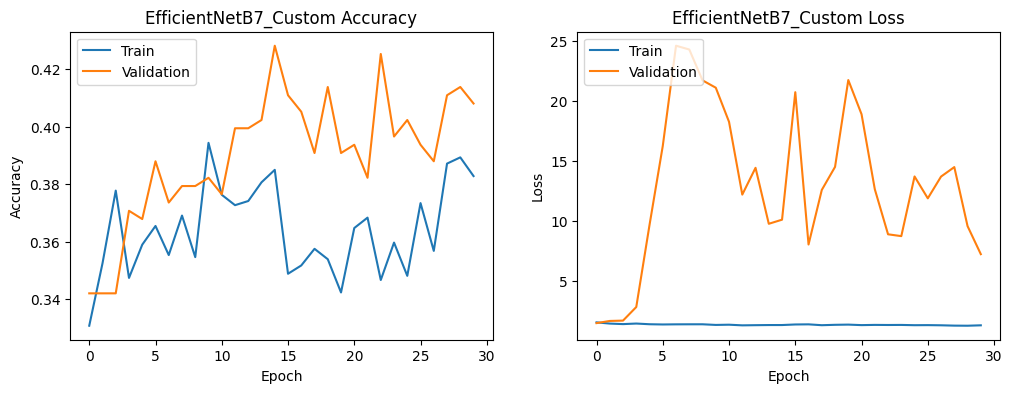

319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.1438 - loss: 29.4541
Test Accuracy: 0.2439
319/319 ━━━━━━━━━━━━━━━━━━━━ 50s 115ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.74      0.13      0.22      1645
        rust       0.00      0.00      0.00       275
        scab       0.24      0.66      0.35       630

    accuracy                           0.24      2550
   macro avg       0.33      0.26      0.19      2550
weighted avg       0.54      0.24      0.23      2550



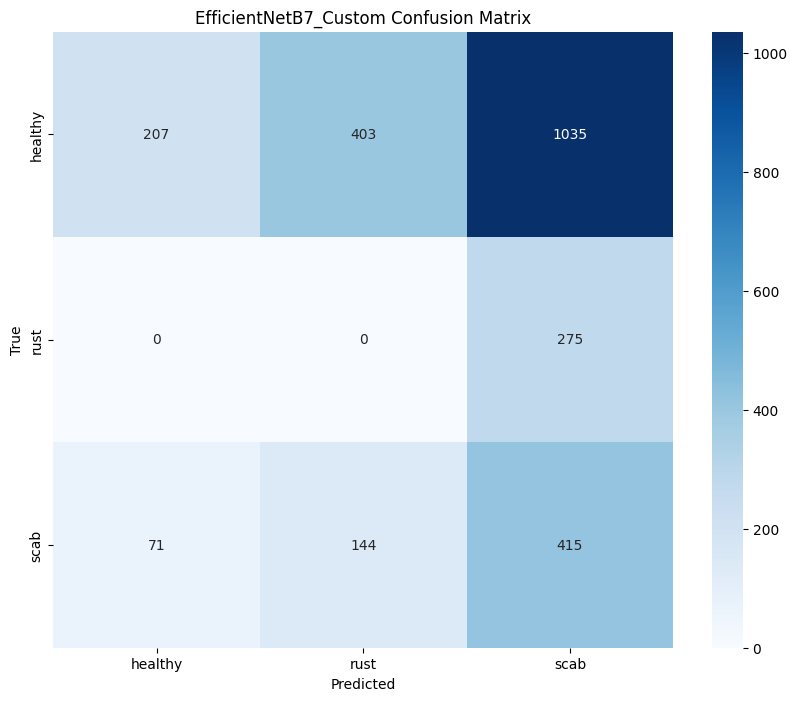

In [11]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_Custom", train_generator, validation_generator, test_generator, 30)

### B7 RTX A40

In [20]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    57,222,263 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,922,938 (220.96 MB)

 Trainable params: 57,636,275 (219.86 MB)

 Non-trainable params: 286,663 (1.09 MB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1729352052.189204    3395 service.cc:146] XLA service 0x71629c014390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729352052.189269    3395 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-10-19 15:34:15.290693: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-19 15:34:24.340277: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8905
E0000 00:00:1729352088.393029    3395 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352088.584163    3395 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1

135/173 ━━━━━━━━━━━━━━━━━━━━ 22s 584ms/step - accuracy: 0.3291 - loss: 1.4415

E0000 00:00:1729352341.561859    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352341.738734    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352342.603626    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352342.750182    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352343.642149    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

173/173 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.3310 - loss: 1.4393 - val_accuracy: 0.2989 - val_loss: 1.2354
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 111s 639ms/step - accuracy: 0.3477 - loss: 1.4143 - val_accuracy: 0.3420 - val_loss: 1.2928
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 561ms/step - accuracy: 0.3676 - loss: 1.3640 - val_accuracy: 0.3448 - val_loss: 1.4572
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 104s 599ms/step - accuracy: 0.3927 - loss: 1.3141 - val_accuracy: 0.3994 - val_loss: 11.2917
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 525ms/step - accuracy: 0.3979 - loss: 1.3161 - val_accuracy: 0.3966 - val_loss: 52.8341
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 89s 513ms/step - accuracy: 0.3597 - loss: 1.3155 - val_accuracy: 0.4052 - val_loss: 54.0727
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 99s 568ms/step - accuracy: 0.3708 - loss: 1.3159 - val_accuracy: 0.3879 - val_loss: 60.1369
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 96s 553ms/step - accuracy: 0.3663 - loss: 1.3408 -

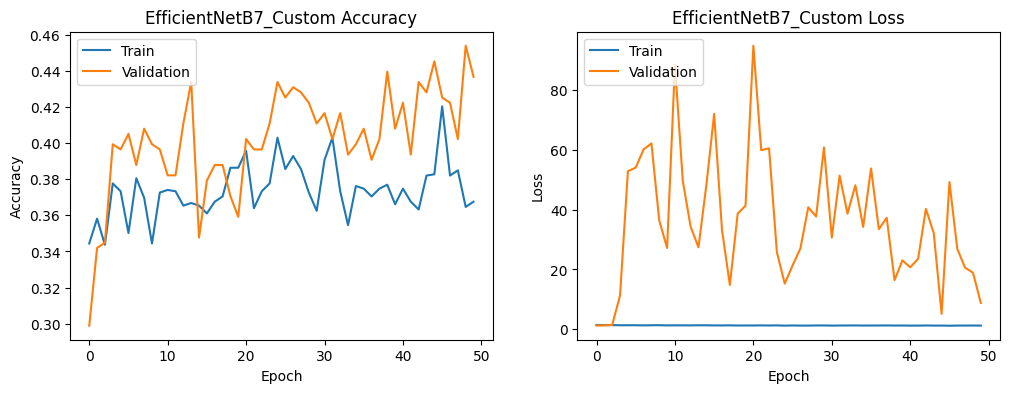

319/319 ━━━━━━━━━━━━━━━━━━━━ 51s 160ms/step - accuracy: 0.3766 - loss: 50.5613
Test Accuracy: 0.3792
319/319 ━━━━━━━━━━━━━━━━━━━━ 72s 168ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.77      0.40      0.53      1645
        rust       0.00      0.00      0.00       275
        scab       0.27      0.49      0.35       630

    accuracy                           0.38      2550
   macro avg       0.35      0.30      0.29      2550
weighted avg       0.56      0.38      0.43      2550



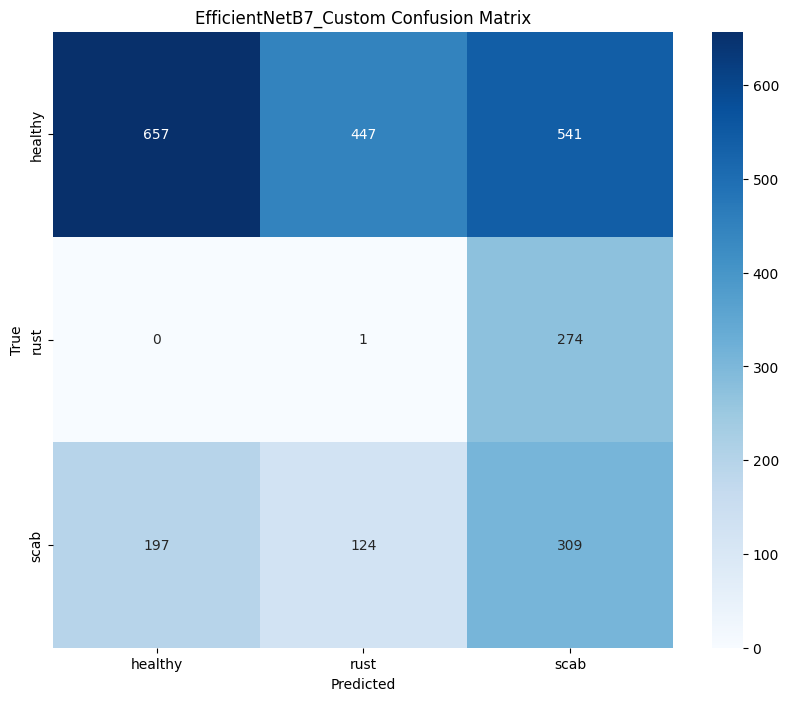

In [21]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_Custom", train_generator, validation_generator, test_generator, 50)